In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from sklearn.metrics import r2_score
import pickle

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict
import copy
from skorch import NeuralNetRegressor
import skorch
import sys
sys.path.insert(1, '../fit')
from dnn_setup import ResNetRegressor, ResidualBlock

In [7]:
import sys
sys.path.insert(1, '/project/cper_neon_aop/hls_nrt/params')
from ltar_reno_params_eval import *

In [51]:
from importlib import reload
import sys
reload(sys.modules["ltar_reno_params_eval"])
from ltar_reno_params_eval import *

In [52]:
with open(os.path.join(inDIR, 'ml_train_' + nickname + '_cv_' + kfold_group + '_tuneby_' + tuneby_group + '_results.pk'), 'rb') as f:
    mod_dict = pickle.load(f)
df = pd.read_csv(inPATH)
save_results = False

In [53]:
id_cols

['Pasture', 'Date', 'Observed']

In [54]:
[x for x in df.columns if x not in drop_cols + var_names + id_cols]

['DW_kg_ha',
 'CPER_2022',
 'OLS_2022',
 'OLS',
 'LASSO',
 'PLS',
 'PCR',
 'SVR',
 'RF',
 'GBR',
 'kfold']

In [55]:
def r_corrcoef(y_obs, y_pred):
    corr_matrix = np.corrcoef(y_obs, y_pred)
    corr = corr_matrix[0,1]
    r = corr
    return r

In [56]:
df_bm_pred = pd.melt(df.drop(columns=drop_cols + var_names).rename(columns={y_col: 'Observed'}), 
                 id_vars=id_cols + [logo_group], 
                 value_name='Predicted',
                 var_name='Source')

In [57]:
df_ens_lin = df_bm_pred[df_bm_pred['Source'].isin(
    ['LASSO', 'PLS', 'PCR'])].groupby(
    [x for x in df_bm_pred.columns if x not in ['Source', 'Predicted']]).mean().reset_index()
df_ens_lin['Source'] = 'ENS_LIN'

df_ens_ml = df_bm_pred[df_bm_pred['Source'].isin(
    ['SVR', 'RF', 'GBR'])].groupby(
    [x for x in df_bm_pred.columns if x not in ['Source', 'Predicted']]).mean().reset_index()
df_ens_ml['Source'] = 'ENS_ML'

df_ens_both = df_bm_pred[df_bm_pred['Source'].isin(
    ['LASSO', 'PLS', 'PCR', 'SVR', 'RF', 'GBR'])].groupby(
    [x for x in df_bm_pred.columns if x not in ['Source', 'Predicted']]).mean().reset_index()
df_ens_both['Source'] = 'ENS_ALL'

In [58]:
df_bm_pred = pd.concat([df_bm_pred, df_ens_lin, df_ens_ml, df_ens_both])

In [59]:
mods = ['CPER_2022', 'OLS_2022', 'OLS', 
        'LASSO', 'PLS', 'PCR', 
        'SVR', 'RF', 'GBR', 'DNN',
        'ENS_LIN', 'ENS_ML', 'ENS_ALL']

In [60]:
df_bm_pred['Source'] = pd.Categorical(df_bm_pred['Source'], 
                                      categories=mods)

In [61]:
df_bm_pred['Source'] = df_bm_pred['Source'].cat.remove_unused_categories()

In [62]:
df_bm_pred[df_bm_pred['Source'].isnull()]

Empty DataFrame
Columns: [Pasture, Date, Observed, kfold, Source, Predicted]
Index: []

In [63]:
df_bm_pred[df_bm_pred['Observed'] == 0]

Empty DataFrame
Columns: [Pasture, Date, Observed, kfold, Source, Predicted]
Index: []

In [64]:
#df_bm_pred = df_bm_pred.groupby([mod_col, logo_group,  id_col, date_col] + group_cols).mean().reset_index().dropna()

In [65]:
mae_obs = df_bm_pred.groupby([mod_col], observed=True).apply(
    lambda x: np.mean(abs(x['Predicted'] - x['Observed']))).round(2)
mape_obs = df_bm_pred.groupby([mod_col], observed=True).apply(
    lambda x: np.mean(abs((x['Predicted'] - x['Observed']) / x['Observed']))).round(2)
r2_obs = df_bm_pred.groupby([mod_col], observed=True).apply(
    (lambda x: r2_score(x['Observed'], x['Predicted']))).round(2)
r2_corr_obs = df_bm_pred.groupby([mod_col], observed=True).apply(
        lambda x: r_corrcoef(x['Observed'], x['Predicted'])).round(2)

In [66]:
df_smry_obs = pd.DataFrame({
    'MAE': mae_obs.round(2),
    'MAE_pct': (mae_obs / df_bm_pred.groupby([mod_col], observed=True).mean()['Observed']).round(2),
    'MAPE': mape_obs.round(2),
    'R^2': r2_obs.round(2),
    'r': r2_corr_obs.round(2)
})
display(df_smry_obs)

MAE  MAE_pct  MAPE   R^2     r
Source                                       
CPER_2022  2229.76     0.71  0.65 -1.61  0.07
OLS_2022   1208.50     0.39  0.46  0.09  0.47
OLS        1054.20     0.34  0.46  0.29  0.56
LASSO       968.49     0.31  0.39  0.38  0.63
PLS        1071.60     0.34  0.46  0.27  0.55
PCR        1089.54     0.35  0.42  0.21  0.52
SVR         987.00     0.32  0.43  0.37  0.61
RF         1084.33     0.35  0.54  0.34  0.58
GBR        1035.73     0.33  0.46  0.34  0.58
ENS_LIN    1013.87     0.32  0.41  0.32  0.59
ENS_ML      997.88     0.32  0.46  0.38  0.62
ENS_ALL     970.28     0.31  0.42  0.38  0.62

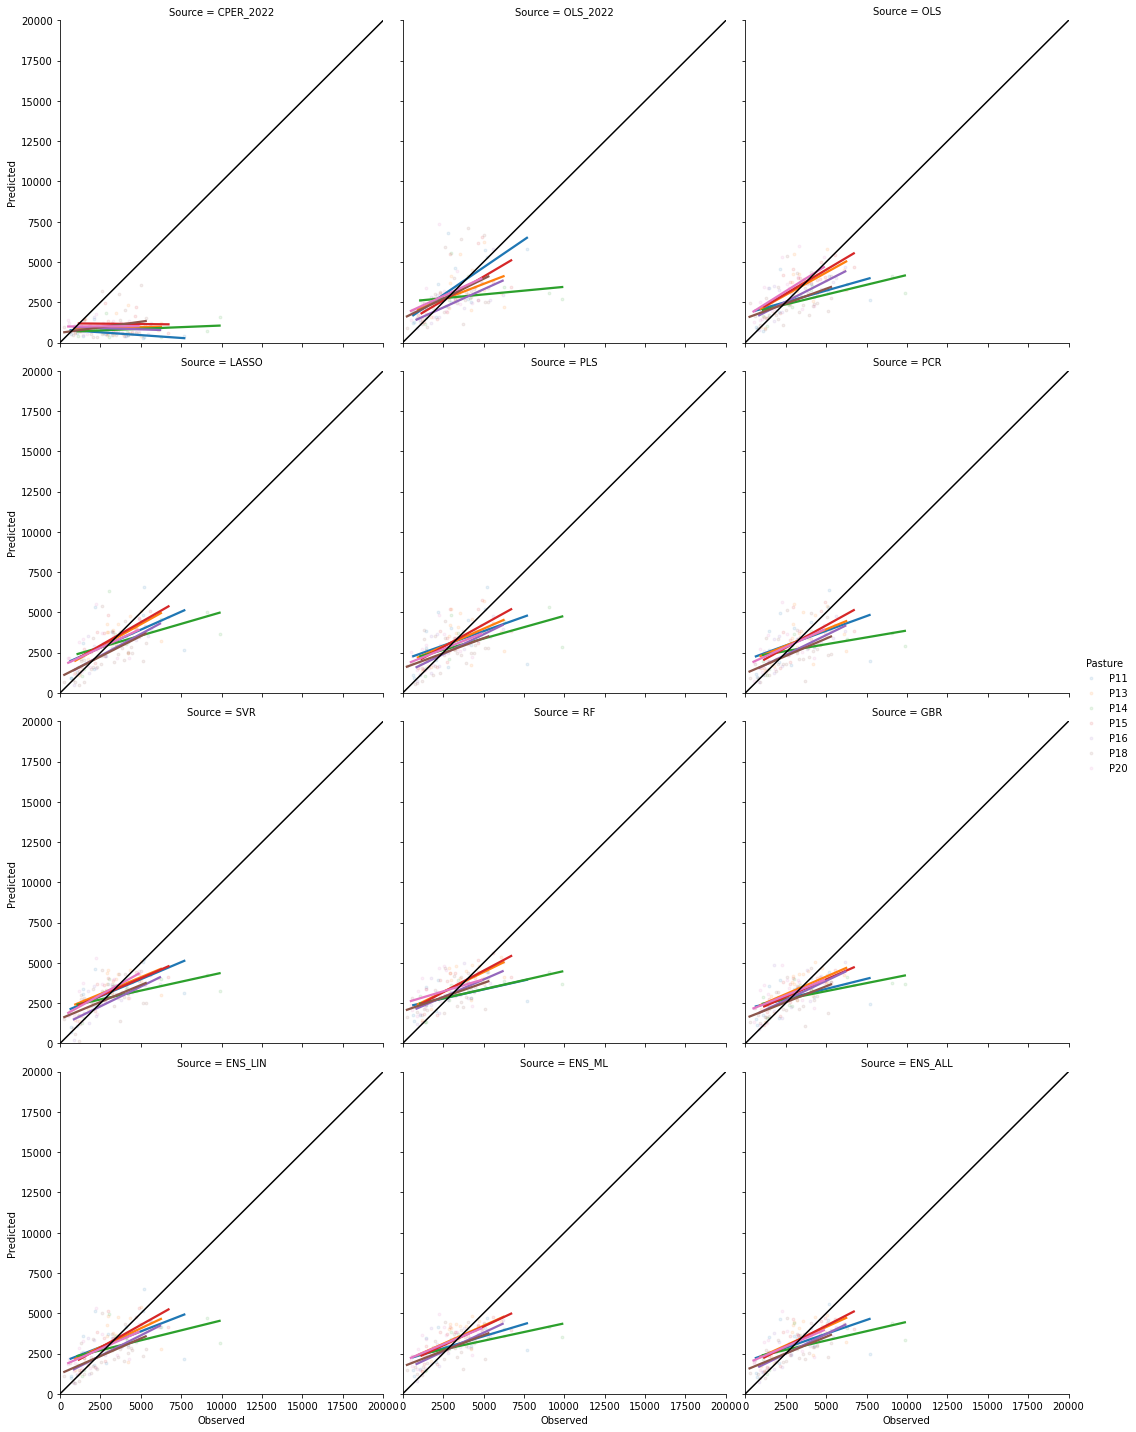

In [67]:
p_obs = sns.lmplot(df_bm_pred,
               x='Observed', y='Predicted', col=mod_col, col_wrap=3, ci=None,
                    scatter_kws={'s': 8, 'alpha': 0.1, 'edgecolor': None})
for ax in p_obs.axes:
    ax.set_ylim((0, 20000))
    ax.set_xlim((0, 20000))
    ax.plot(np.arange(0, 20000), np.arange(0, 20000), c='black')

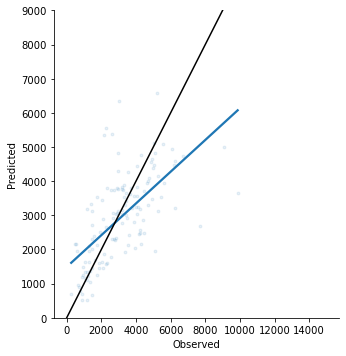

In [69]:
p_obs_best = sns.lmplot(df_bm_pred[df_bm_pred[mod_col] == 'LASSO'],
               x='Observed', y='Predicted', ci=None,
                    scatter_kws={'s': 8, 'alpha': 0.1, 'edgecolor': None})
for ax in p_obs_best.axes.flatten():
        ax.set_ylim((0, 9000))
        ax.plot(np.arange(0, 15000), np.arange(0, 15000), c='black')

In [70]:
mae_plot = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby([id_col, date_col]).apply(lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed']))).mean()).round(2)
mape_plot = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby([id_col, date_col]).apply(lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed'])) / np.mean(x['Observed'])).mean()).round(2)
r2_plot = df_bm_pred.groupby([mod_col, 
                              logo_group, 
                              id_col, 
                              date_col]).mean().reset_index().dropna().groupby([mod_col, logo_group], 
                                                                               observed=True).apply(
    (lambda x: r2_score(x['Observed'], x['Predicted']))).round(2)
r2_corr_plot = df_bm_pred.groupby([mod_col, 
                                   logo_group, 
                                   id_col, 
                                   date_col]).mean().reset_index().dropna().groupby([mod_col, logo_group],
                                                                                    observed=True).apply(
    lambda x: r_corrcoef(x['Observed'], x['Predicted'])).round(2)

In [71]:
df_smry_plot = pd.DataFrame({
    'MAE': mae_plot.unstack(level=0).mean().round(2),
    'MAE_pct': (mae_plot / df_bm_pred.groupby([mod_col, logo_group], observed=True).mean()['Observed']).unstack(level=0).mean().round(2),
    'MAPE': mape_plot.unstack(level=0).mean().round(2),
    'R^2': r2_plot.unstack(level=0).mean().round(2),
    'r': r2_corr_plot.unstack(level=0).mean().round(2)
})
display(df_smry_plot)
if save_results:
    df_smry_plot.to_csv('results/tables/ml_models/ml_yrly_pred_plot_from_' + prefix + '_tuneby_' + tuneby_group + '.csv')

df_smry_plot_by_yr = pd.DataFrame({
    'MAE': mae_plot.round(2),
    'MAPE': mape_plot.round(2),
    'R^2': r2_plot.round(2),
    'r': r2_corr_plot.round(2)
})
#display(df_smry_plot_by_yr)
if save_results:
    df_smry_plot_by_yr.to_csv('results/tables/ml_models/ml_yrly_pred_plot_from_' + prefix + '_tuneby_' + tuneby_group + '_yearly.csv')

MAE  MAE_pct  MAPE   R^2     r
Source                                       
CPER_2022  2342.48     0.72  0.65 -1.97 -0.01
OLS_2022   1245.26     0.39  0.44 -0.01  0.50
OLS        1073.01     0.35  0.42  0.23  0.64
LASSO      1008.46     0.32  0.38  0.32  0.65
PLS        1104.27     0.35  0.43  0.20  0.56
PCR        1123.16     0.36  0.40  0.14  0.56
SVR        1024.74     0.32  0.40  0.31  0.65
RF         1119.62     0.36  0.51  0.23  0.61
GBR        1084.74     0.35  0.44  0.26  0.60
ENS_LIN    1051.84     0.33  0.40  0.26  0.61
ENS_ML     1033.39     0.33  0.43  0.31  0.65
ENS_ALL    1010.72     0.32  0.40  0.32  0.64

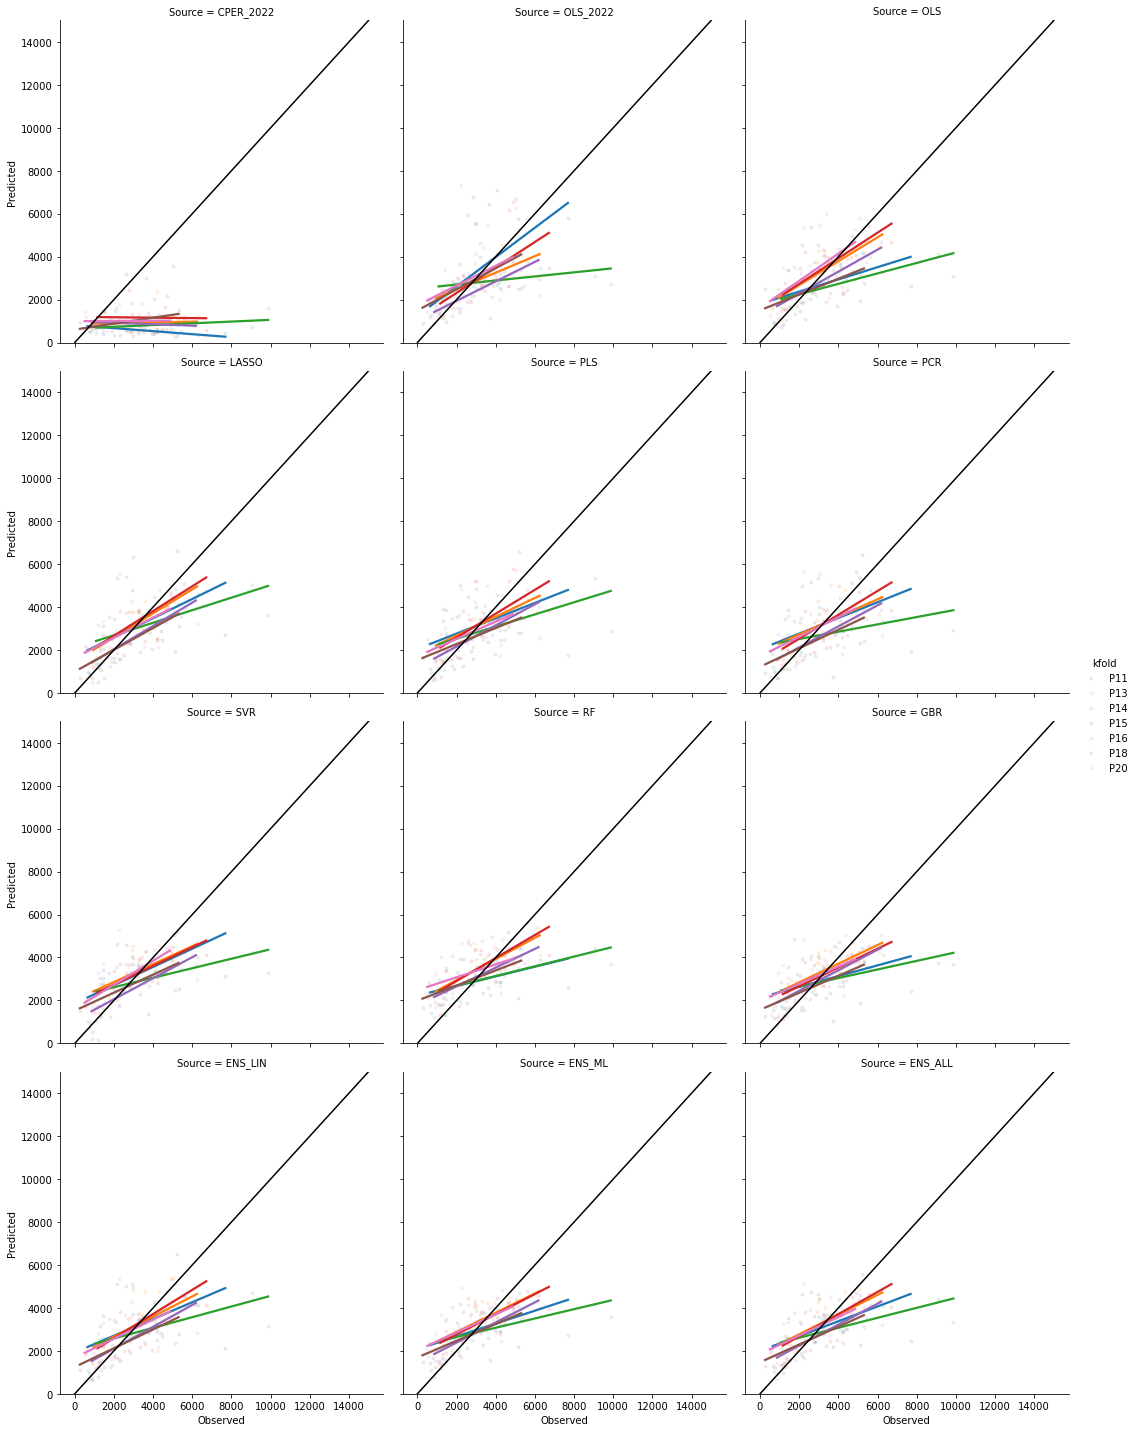

In [72]:
p_plot = sns.lmplot(df_bm_pred.groupby([mod_col, logo_group, id_col, date_col]).mean().reset_index(),
               x='Observed', y='Predicted', col=mod_col, col_wrap=3,
               hue=logo_group, ci=None,
                    scatter_kws={'s': 8, 'alpha': 0.1, 'edgecolor': None})
for ax in p_plot.axes:
        ax.set_ylim((0, 15000))
        ax.plot(np.arange(0, 15000), np.arange(0, 15000), c='black')
if save_results:
    plt.savefig(os.path.join(outDIR, 'ml_yrly_pred_plot_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)

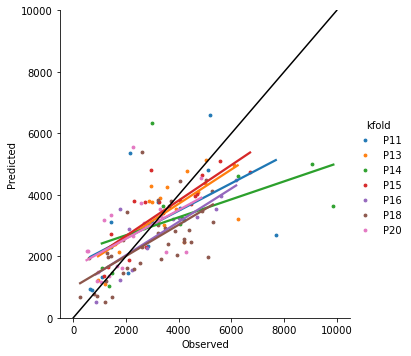

In [105]:
p_plot_best = sns.lmplot(df_bm_pred[df_bm_pred[mod_col] == 'LASSO'],
               x='Observed', y='Predicted',
               hue=logo_group, ci=None,
                    scatter_kws={'s': 8, 'alpha': 1, 'edgecolor': None})
for ax in p_plot_best.axes.flatten():
    ax.set_ylim((0, 10000))
    ax.plot(np.arange(0, 10000), np.arange(0, 10000), c='black')

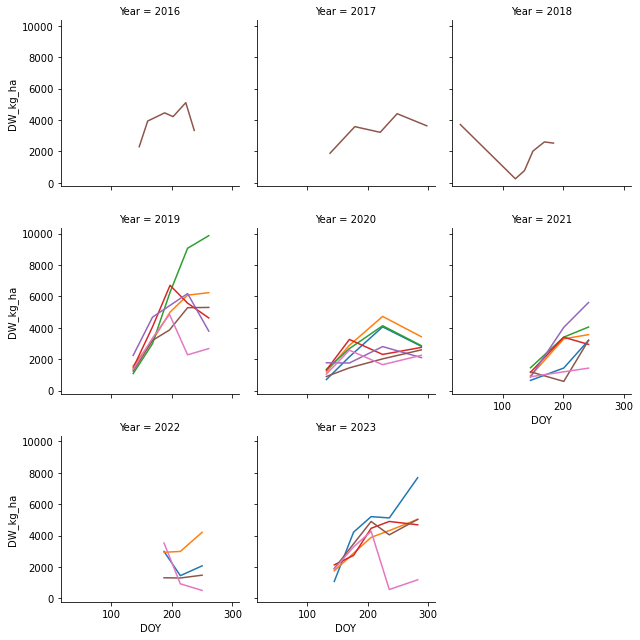

In [104]:
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%b')

df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['DOY'] = df['Date'].dt.dayofyear
p = sns.FacetGrid(hue='Pasture', data=df,
            col='Year', col_wrap=3, sharex=True)
p.map(plt.plot, 'DOY', 'DW_kg_ha')
#xformatter = mdates.DateFormatter("%m/%d")
#p.axes[0,0].xaxis.set_major_formatter(xformatter)
#for ax in p.axes.flatten():
#    ax.xaxis.set_major_formatter(myFmt)

In [21]:
mae_pasture = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby([past_col] + group_cols).apply(lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed']))).mean()).round(2)
mape_pasture = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby([past_col] + group_cols).apply(lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed'])) / np.mean(x['Observed'])).mean()).round(2)
r2_pasture = df_bm_pred.groupby([mod_col, past_col] + group_cols, observed=True).mean().reset_index().dropna().groupby([mod_col, logo_group], observed=True).apply(
    lambda x: r2_score(x['Observed'], x['Predicted'])).round(2)
r2_corr_pasture = df_bm_pred.groupby([mod_col, past_col] + group_cols, observed=True).mean().reset_index().dropna().groupby([mod_col, logo_group], observed=True).apply(
    lambda x: r_corrcoef(x['Observed'], x['Predicted'])).round(2)

In [22]:
df_smry_pasture = pd.DataFrame({
    'MAE': mae_pasture.unstack(level=0).mean().round(2),
    'MAPE': mape_pasture.unstack(level=0).mean().round(2),
    'R^2': r2_pasture.unstack(level=0).mean().round(2),
    'r': r2_corr_pasture.unstack(level=0).mean().round(2)
})
display(df_smry_pasture)
if save_results:
    df_smry_pasture.to_csv('results/tables/ml_models/ml_yrly_pred_pasture_from_' + prefix + '_tuneby_' + tuneby_group + '.csv')

df_smry_pasture_by_yr = pd.DataFrame({
    'MAE': mae_pasture.round(2),
    'MAPE': mape_pasture.round(2),
    'R^2': r2_pasture.round(2),
    'r': r2_corr_pasture.round(2)
})
#display(df_smry_pasture_by_yr.sort_values('r'))
if save_results:
    df_smry_pasture_by_yr.to_csv('results/tables/ml_models/ml_yrly_pred_pasture_from_' + prefix + '_tuneby_' + tuneby_group + '_yearly.csv')

MAE  MAPE   R^2     r
Source                             
CPER_2022  763.66  0.81 -8.31  0.41
OLS_2022   475.55  0.55 -1.28  0.70
OLS        451.29  0.54 -0.99  0.68
LASSO      456.02  0.49 -0.67  0.82
PLS        535.33  0.58 -3.89  0.60
PCR        414.30  0.49 -1.29  0.63
SVR        459.32  0.55 -1.39  0.70
RF         400.18  0.58 -0.05  0.72
GBR        367.33  0.45  0.16  0.84
ENS_LIN    458.53  0.51 -1.51  0.65
ENS_ML     392.96  0.50 -0.20  0.72
ENS_ALL    414.89  0.49 -0.66  0.70

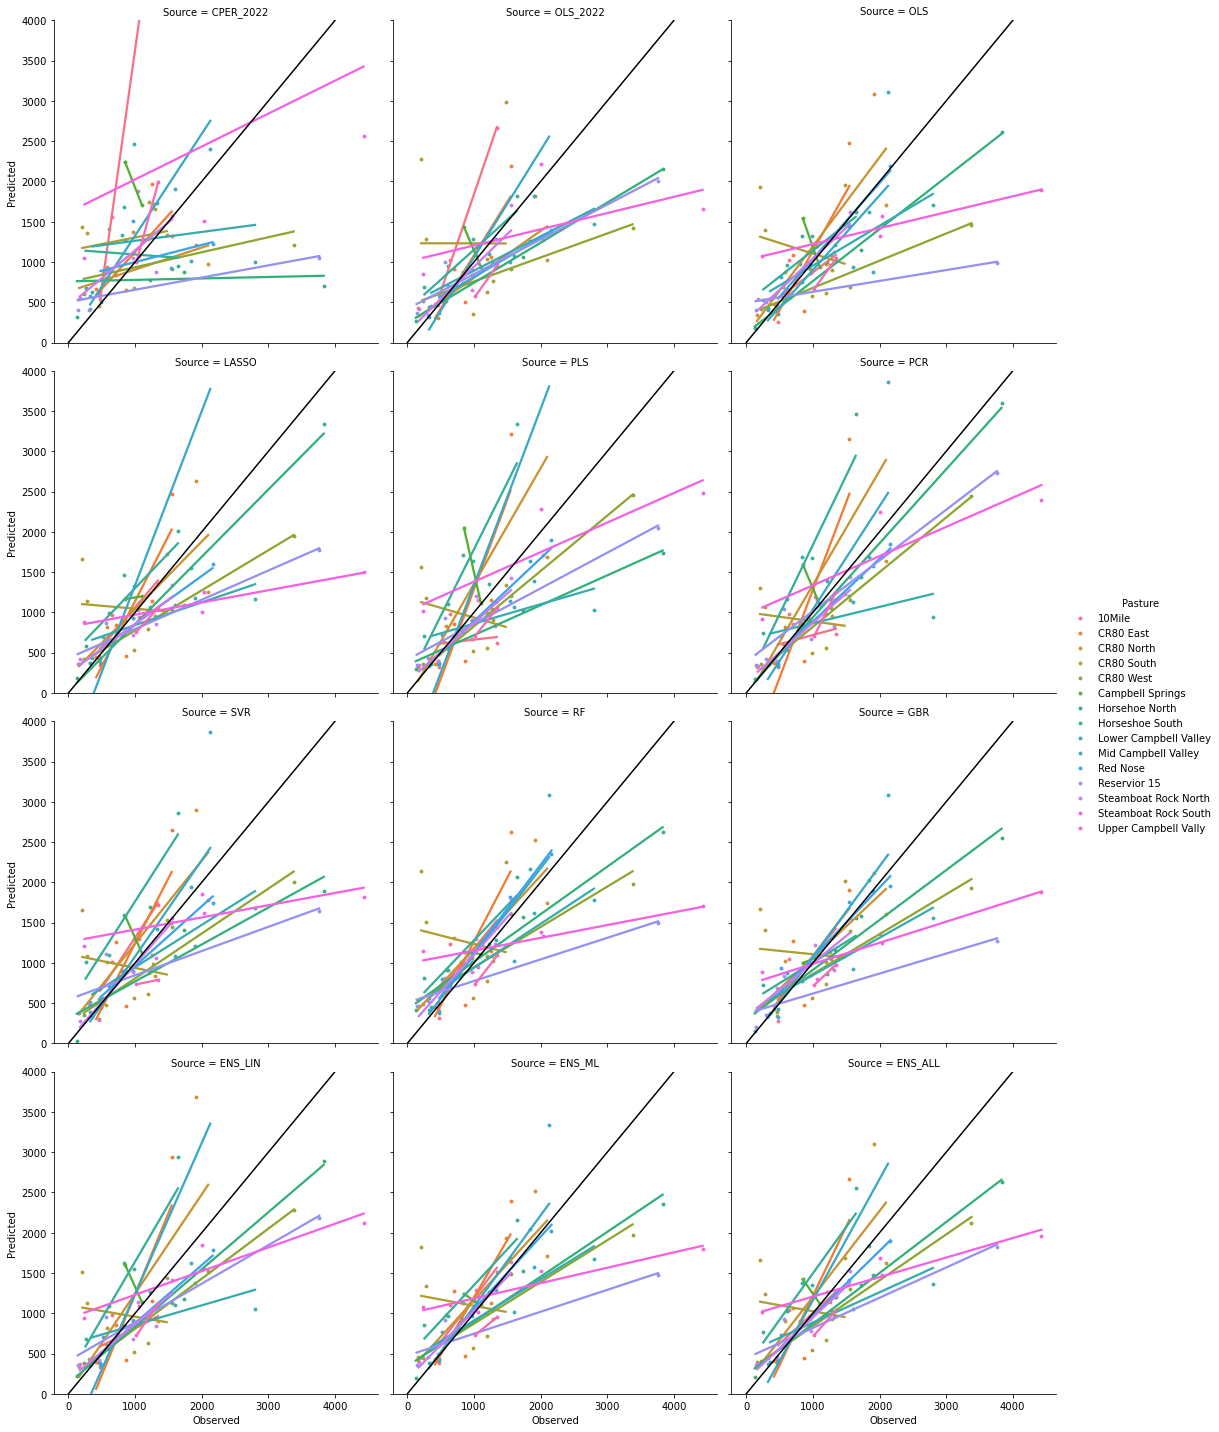

In [23]:
p_past = sns.lmplot(df_bm_pred.groupby(list(set([mod_col, logo_group, past_col] + group_cols))).mean().reset_index(),
               x='Observed', y='Predicted', col=mod_col, col_wrap=3,
               hue=logo_group, ci=None,
                    scatter_kws={'s': 8, 'alpha': 1, 'edgecolor': None})
for ax in p_past .axes:
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join(outDIR, 'ml_yrly_pred_past_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)

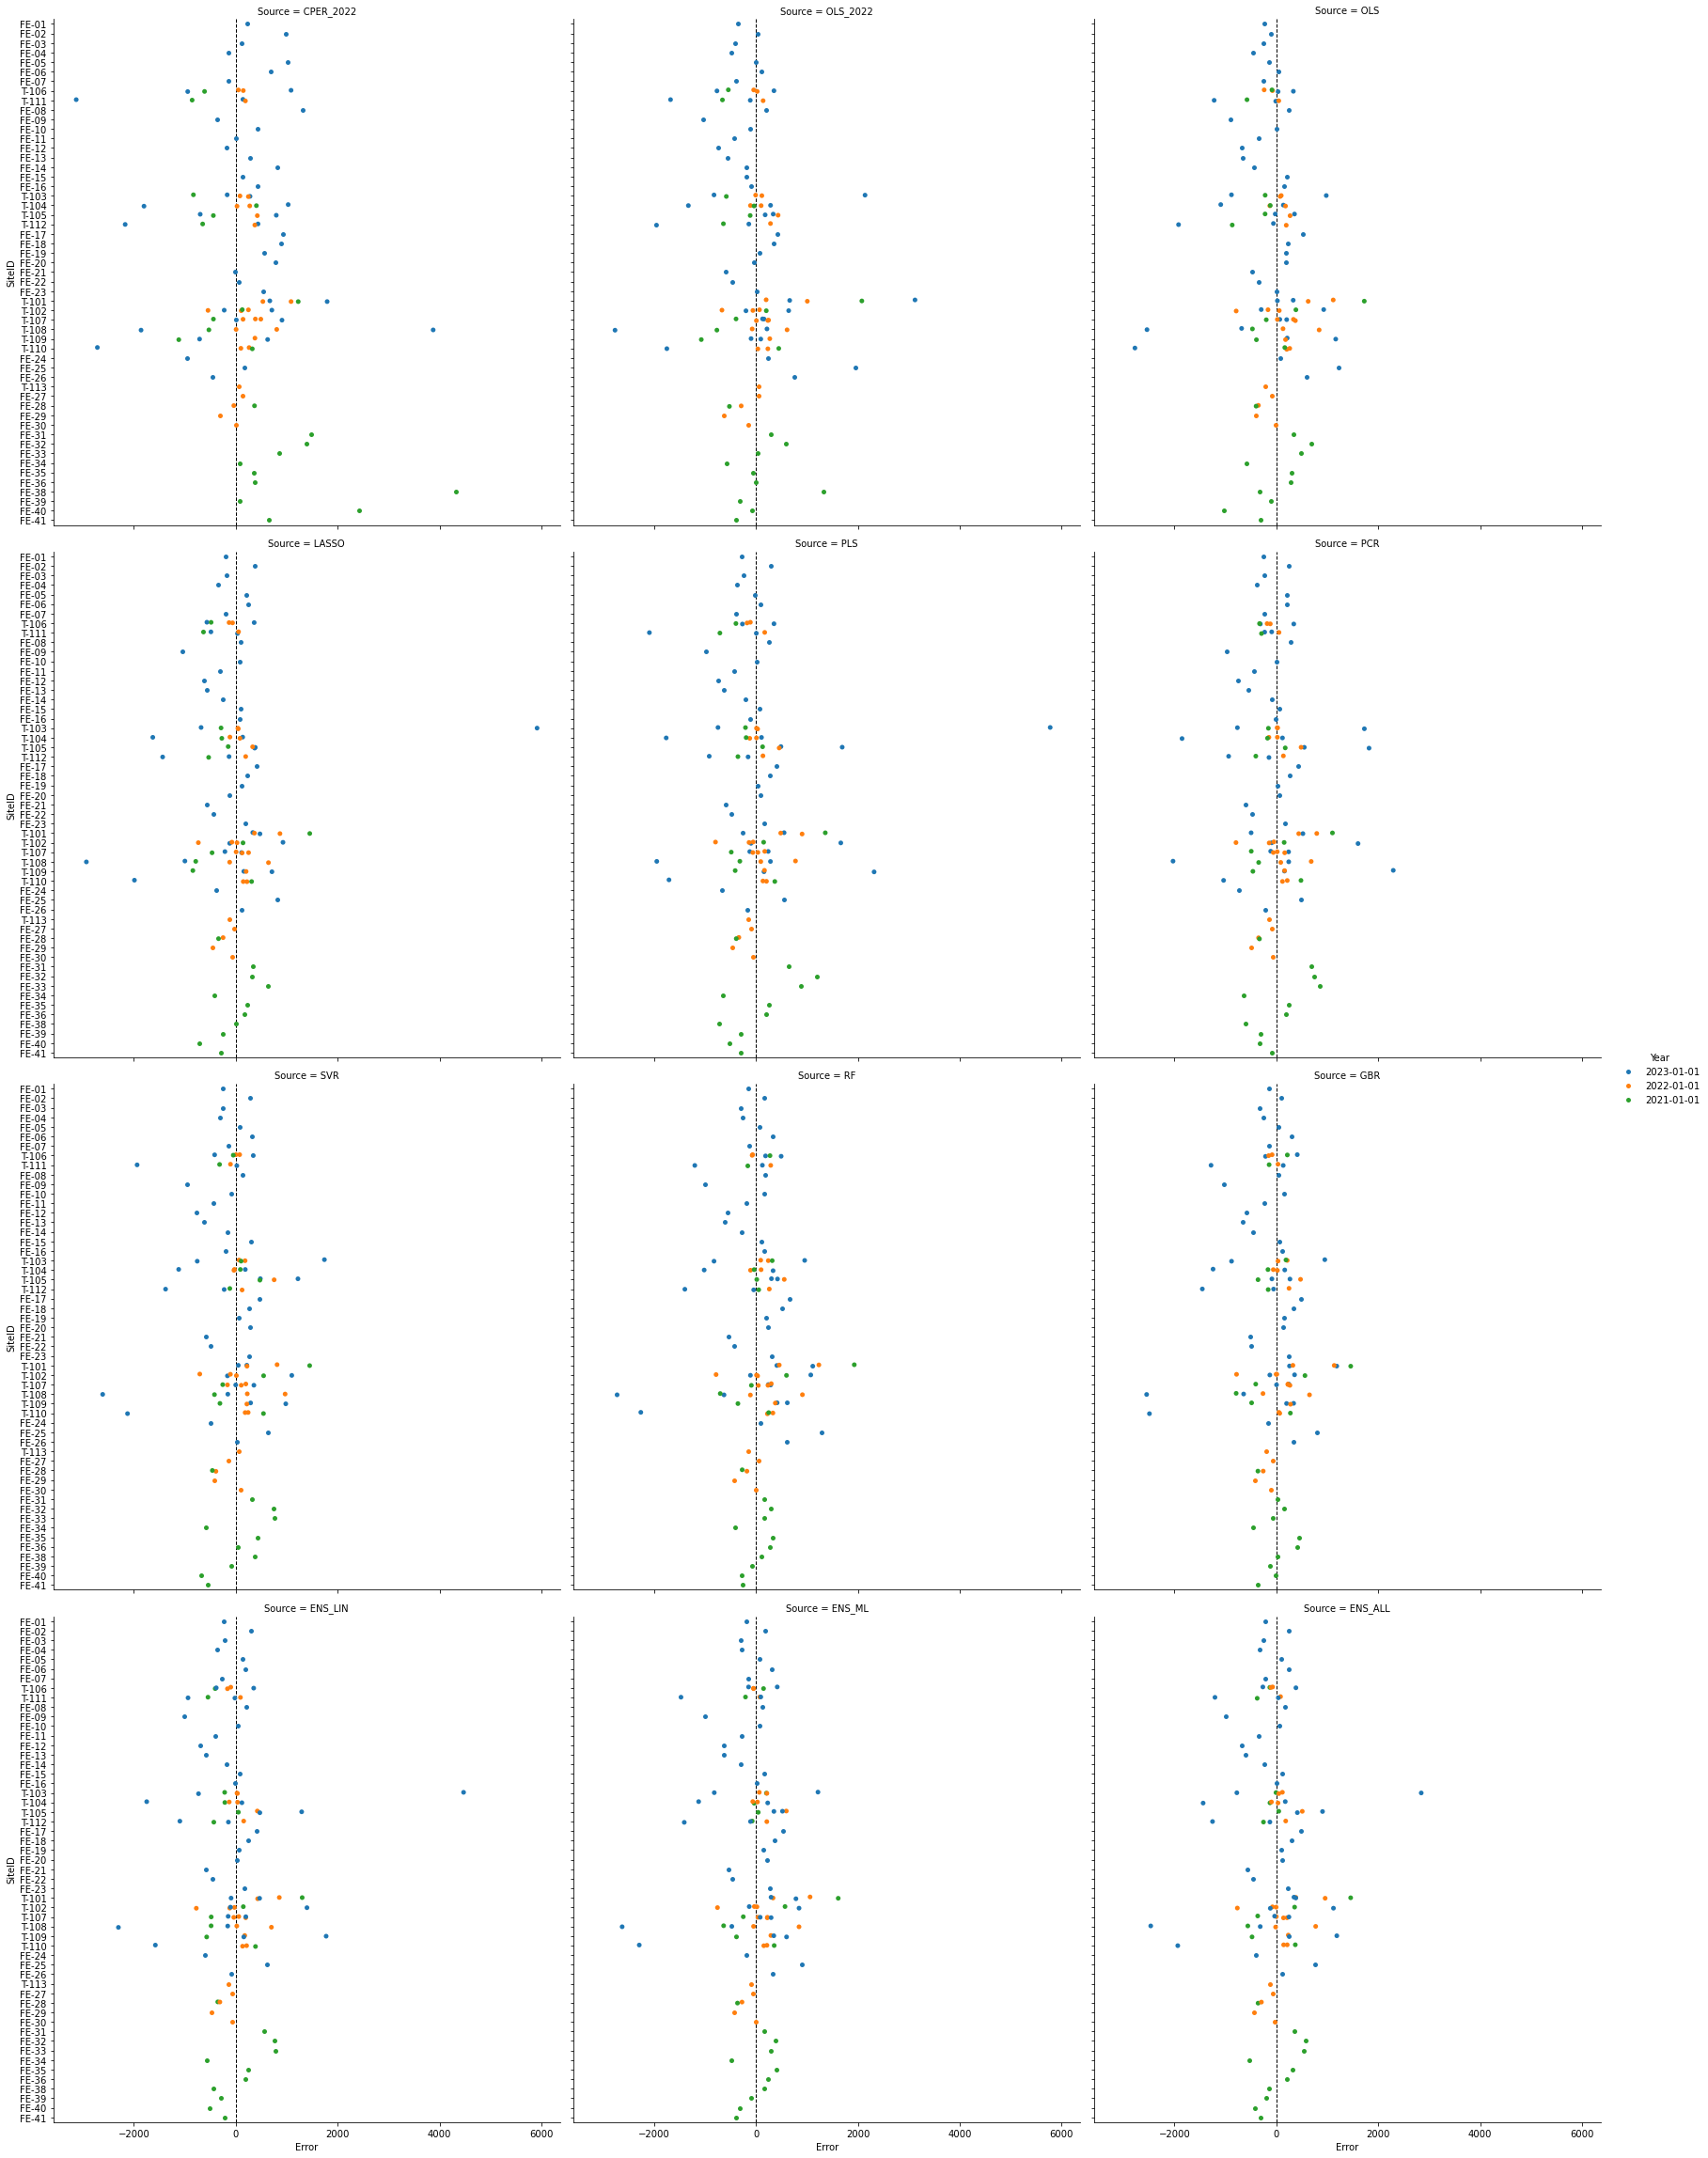

In [23]:
df_bm_pred['Error'] = df_bm_pred['Predicted'] - df_bm_pred['Observed']
p_plot_error = sns.catplot(y=id_col, x='Error', hue='Year',# hue_order=['Band', 'Veg. Index', 'BAI'],
                orient='h', col='Source', col_wrap=3,# palette=sns.color_palette()[6:-1],
                data=df_bm_pred,
                height=8, aspect=1.0)
for ax in p_plot_error.axes.flatten():
    ax.axvline(x=0, linewidth=1, linestyle='dashed', color='black')

In [47]:
df_bm_pred[df_bm_pred['Source'] == 'GBR'].groupby('SiteID').mean().sort_values('Error')

Observed         Year    Predicted        Error
SiteID                                                    
FE-24   1944.000000  2023.000000   856.352819 -1087.647181
FE-09   2040.000000  2023.000000  1102.933991  -937.066009
FE-12   1496.000000  2023.000000   856.959688  -639.040312
T-108   1955.533333  2022.200000  1359.413785  -596.119548
FE-26   1436.000000  2023.000000   856.352819  -579.647181
FE-21   1496.000000  2023.000000   921.251754  -574.748246
FE-04    986.000000  2023.000000   432.409419  -553.590581
FE-22   1292.000000  2023.000000   753.420633  -538.579367
FE-13   1632.000000  2023.000000  1141.989796  -490.010204
FE-41   1349.000000  2021.000000   864.496169  -484.503831
FE-07    884.000000  2023.000000   471.767751  -412.232249
T-111   1591.583333  2022.250000  1181.097441  -410.485892
FE-34   1201.000000  2021.000000   800.373631  -400.626369
FE-11   1088.000000  2023.000000   711.541976  -376.458024
T-112   1555.500000  2022.250000  1201.488734  -354.011266
FE-03   1054.000000  2023.000000   724.444409  -329.555591
FE-39    973.000000  2021.000000   679.518615  -293.481385
T-110   1191.500000  2022.000000   901.913945  -289.586055
FE-40   1900.000000  2021.000000  1615.674049  -284.325951
FE-01   1156.000000  2023.000000   895.740580  -260.259420
FE-14   1428.000000  2023.000000  1295.845451  -132.154549
FE-38   1343.000000  2021.000000  1228.473604  -114.526396
FE-25   1008.000000  2023.000000   901.086537  -106.913463
FE-31    988.000000  2021.000000   883.400966  -104.599034
FE-28   1038.500000  2021.500000   947.862961   -90.637039
FE-15    748.000000  2023.000000   667.809302   -80.190698
FE-29    988.000000  2022.000000   921.273507   -66.726493
T-104   1162.600000  2022.200000  1101.462726   -61.137274
FE-32    849.000000  2021.000000   829.444637   -19.555363
T-103   1271.533333  2022.200000  1261.824090    -9.709243
T-109   1238.416667  2022.250000  1251.202141    12.785474
FE-16    816.000000  2023.000000   849.460202    33.460202
FE-33    836.000000  2021.000000   901.373283    65.373283
FE-05   1088.000000  2023.000000  1157.348341    69.348341
FE-20   1156.000000  2023.000000  1252.817408    96.817408
FE-10    884.000000  2023.000000  1024.069878   140.069878
T-106   1083.266667  2022.200000  1228.843477   145.576811
FE-36    524.000000  2021.000000   671.963977   147.963977
FE-19    748.000000  2023.000000   899.747798   151.747798
FE-08   1088.000000  2023.000000  1245.640029   157.640029
FE-02   1054.000000  2023.000000  1219.783940   165.783940
T-102    942.944444  2022.166667  1118.901256   175.956812
T-105    932.333333  2022.250000  1121.658743   189.325410
FE-06    714.000000  2023.000000   929.774842   215.774842
FE-23    816.000000  2023.000000  1049.722328   233.722328
T-107    842.666667  2022.166667  1124.164316   281.497650
FE-35    581.000000  2021.000000   943.825486   362.825486
FE-17    476.000000  2023.000000   923.868620   447.868620
FE-30    456.000000  2022.000000   934.060246   478.060246
T-113    476.000000  2022.000000   973.457543   497.457543
FE-27    456.000000  2022.000000   980.889233   524.889233
FE-18    816.000000  2023.000000  1355.093587   539.093587
T-101    669.200000  2022.200000  1236.259748   567.059748

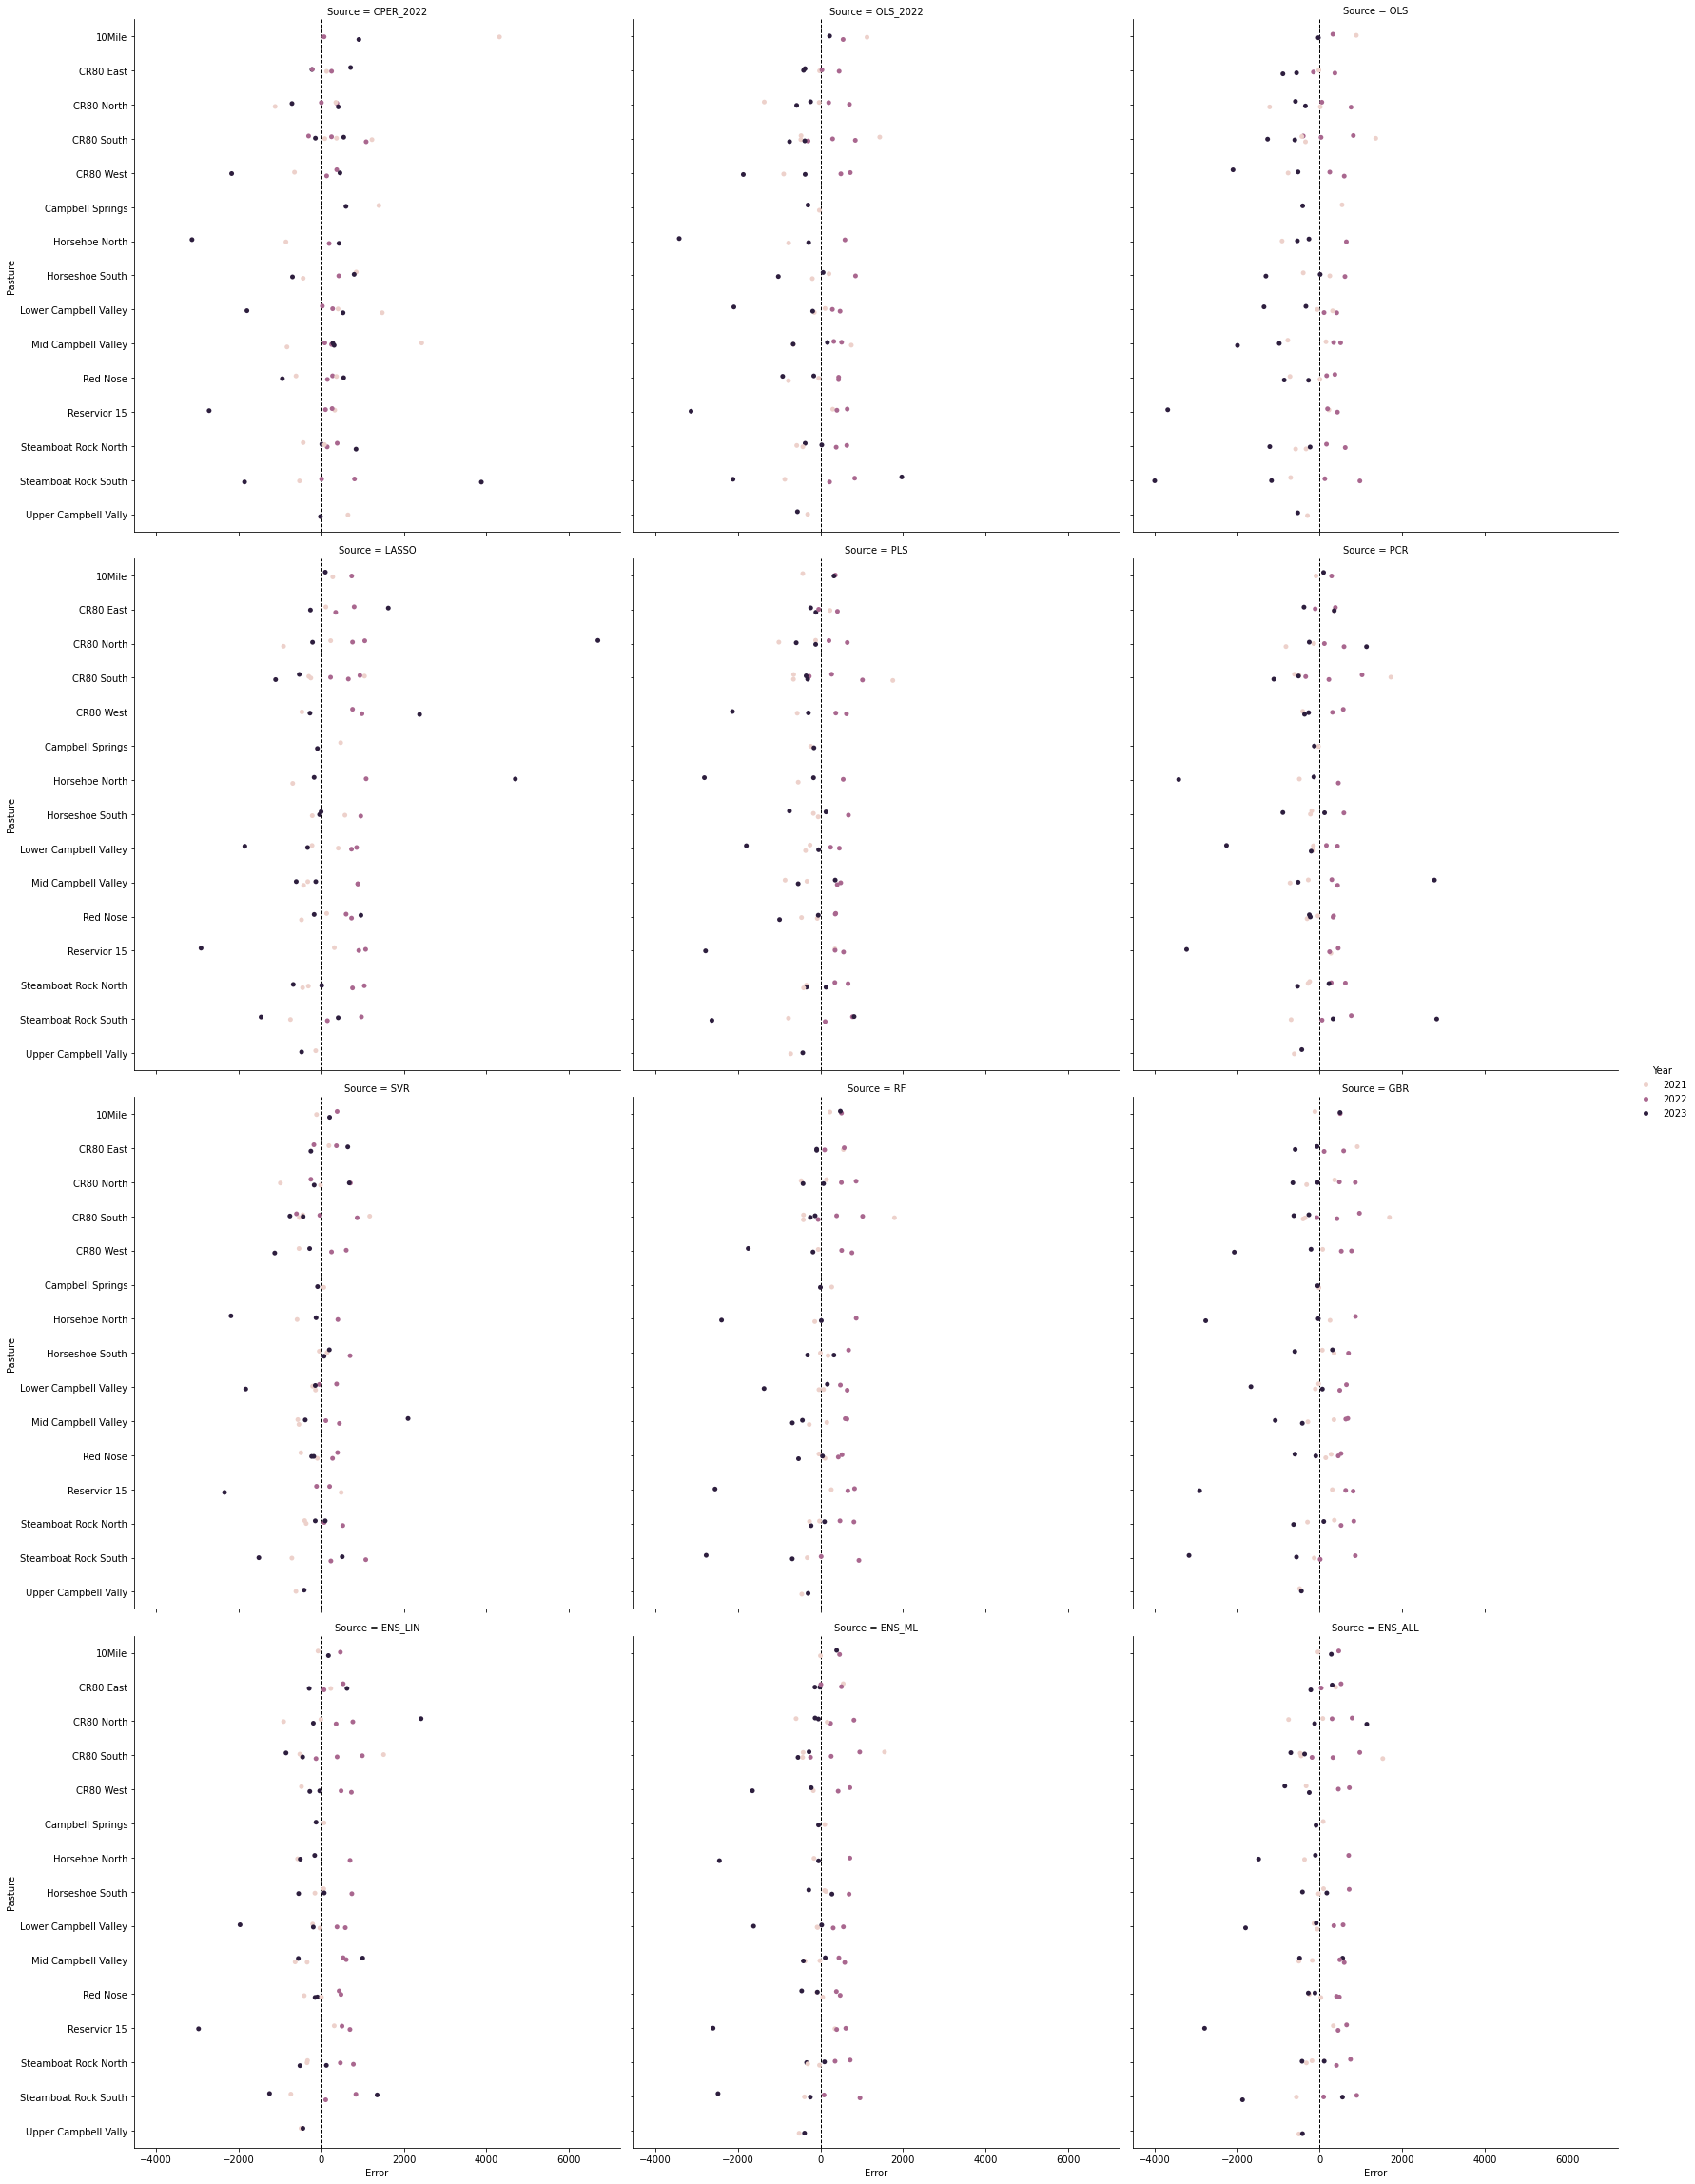

In [48]:
p_past_error = sns.catplot(y=past_col, x='Error', hue='Year',
                orient='h', col='Source', col_wrap=3,# palette=sns.color_palette()[6:-1],
                data=df_bm_pred.groupby(list(set([mod_col, logo_group, past_col] + group_cols))).mean().reset_index(),
                height=8, aspect=1.0)
for ax in p_past_error.axes.flatten():
    ax.axvline(x=0, linewidth=1, linestyle='dashed', color='black')

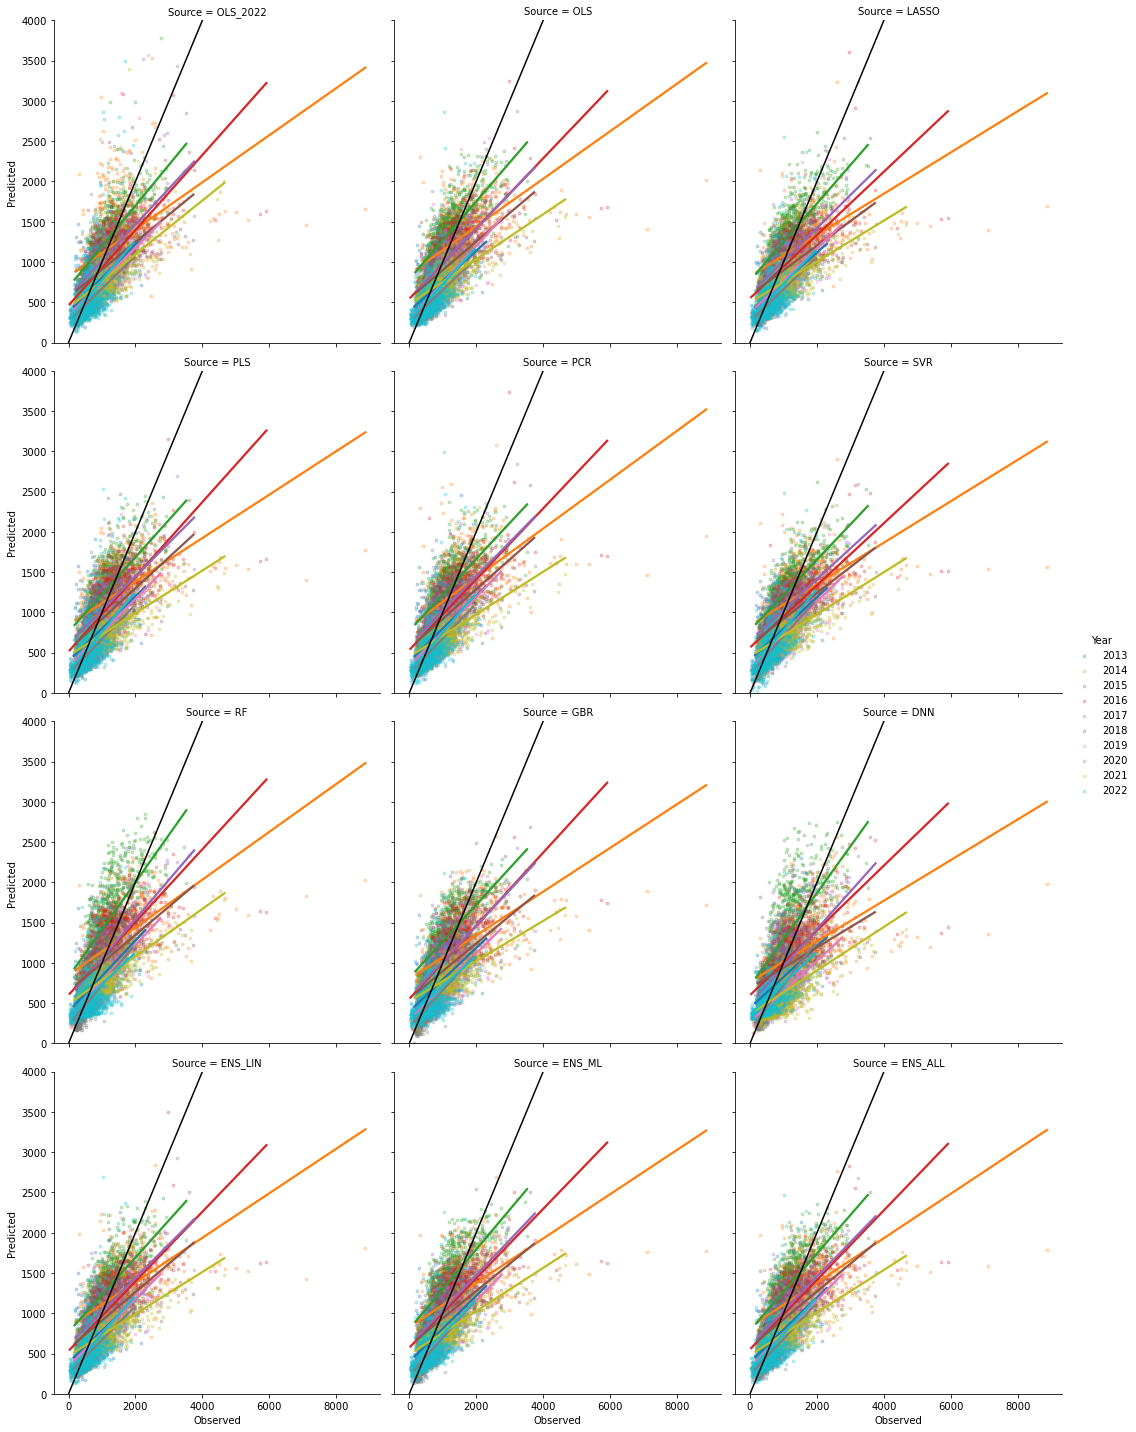

In [14]:
if 'Transect' in df_bm_pred.columns:
    p_trans = sns.lmplot(df_bm_pred, x='Observed', y='Predicted', col='Source', col_wrap=3, hue='Year', ci=None,
                         scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
    for ax in p_trans.axes:
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
    if save_results:
        plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_transect_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)
else:
    p_trans=None

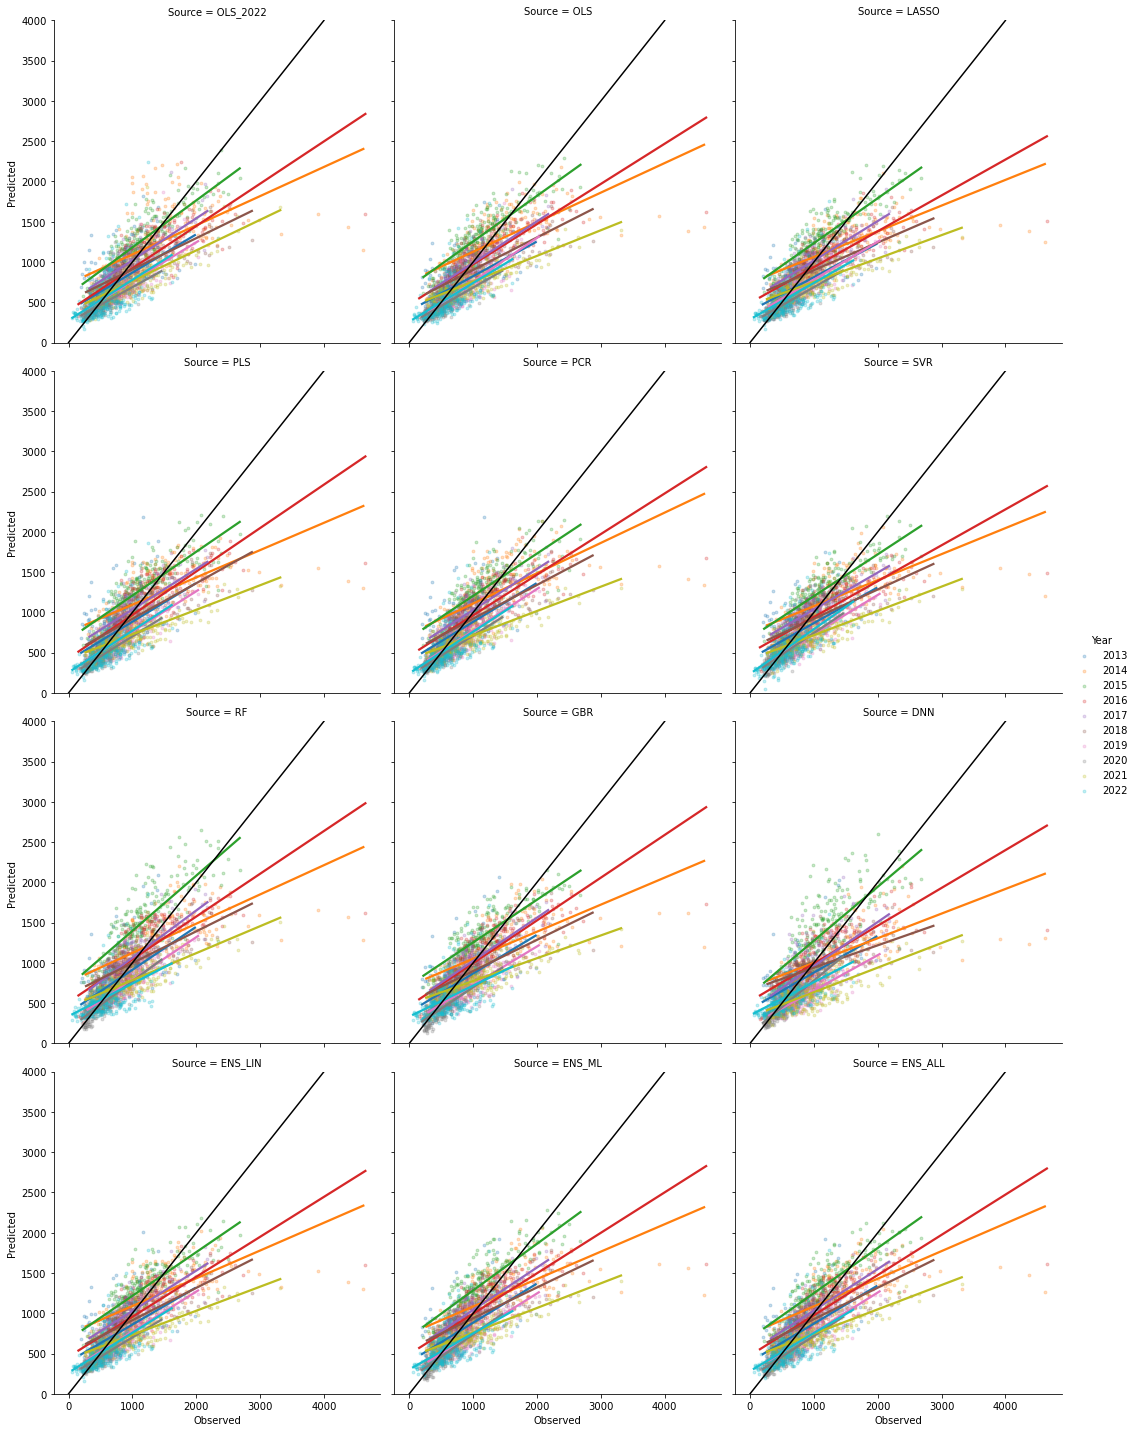

In [15]:
p_plot = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Plot', 'Date_mean']).mean().reset_index(),
               x='Observed', y='Predicted', col='Source', col_wrap=3,
               hue='Year', ci=None,
                    scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_plot.axes:
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_plot_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)

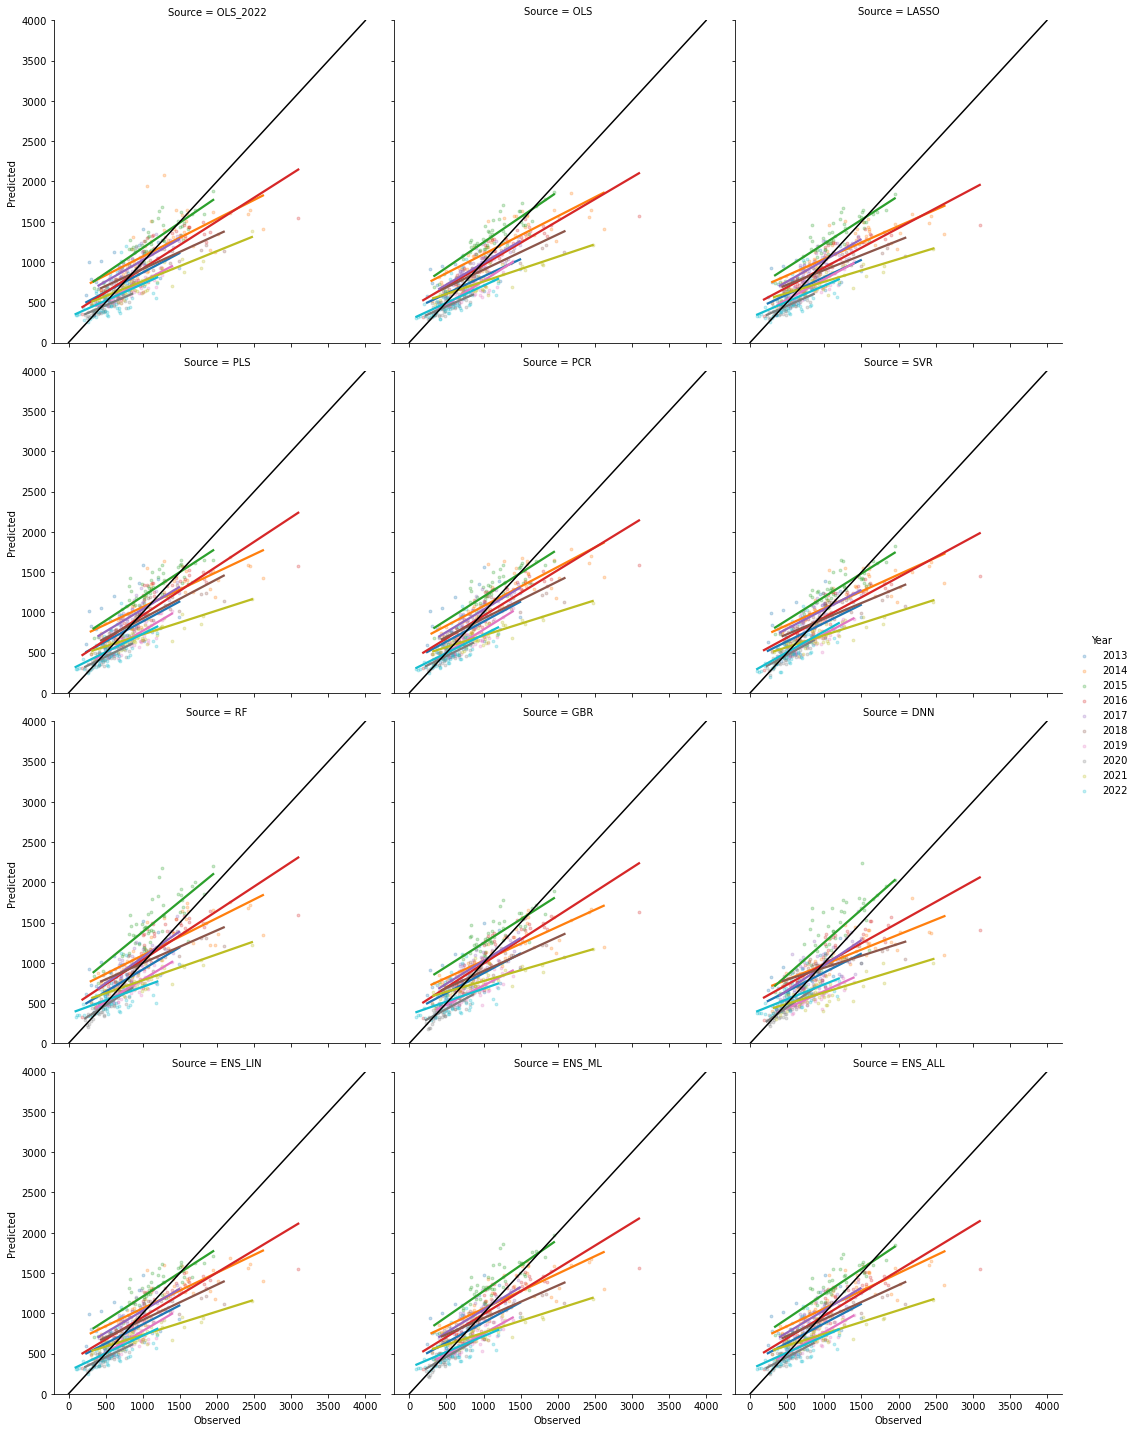

In [16]:
p_pasture = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Date_mean']).mean().reset_index(), 
               x='Observed', y='Predicted', col='Source', col_wrap=3, 
               hue='Year', ci=None, 
                       scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_pasture.axes:
    ax.set_ylim((0, 4000))
    ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_pasture_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)

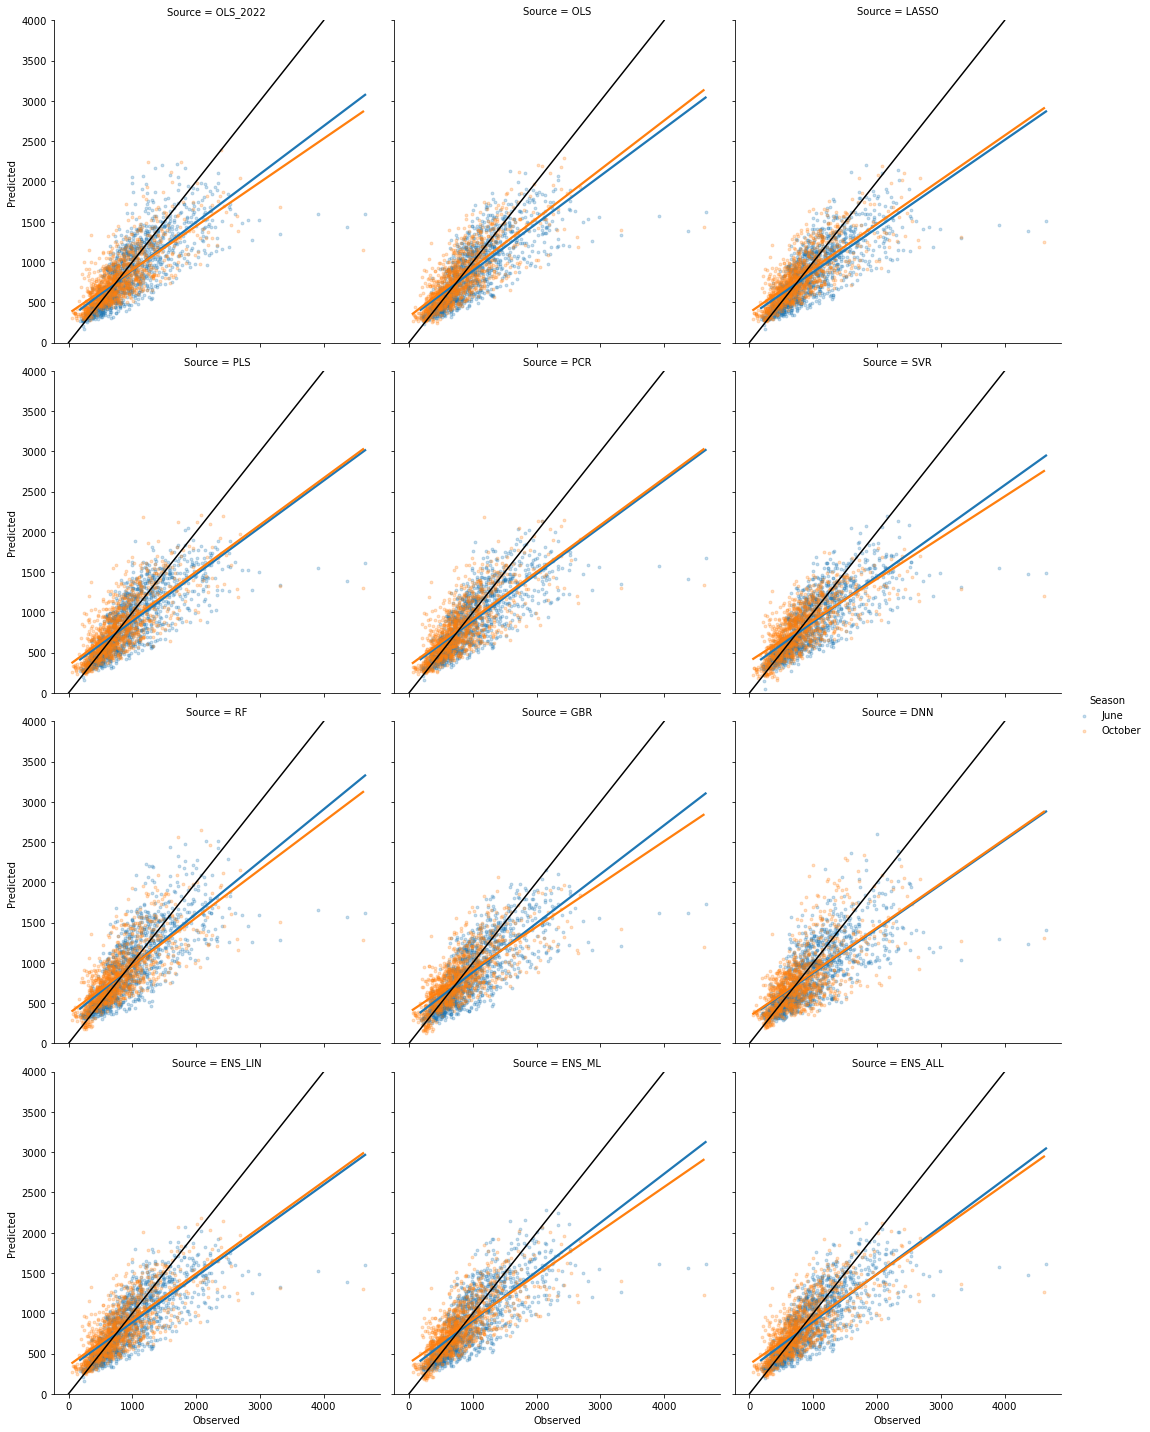

In [17]:
p_plot_seas = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Plot', 'Date_mean', 'Season']).mean().reset_index(),
               x='Observed', y='Predicted', col='Source', col_wrap=3,
               hue='Season', ci=None,
                    scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_plot_seas.axes:
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_plot_by_season_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)

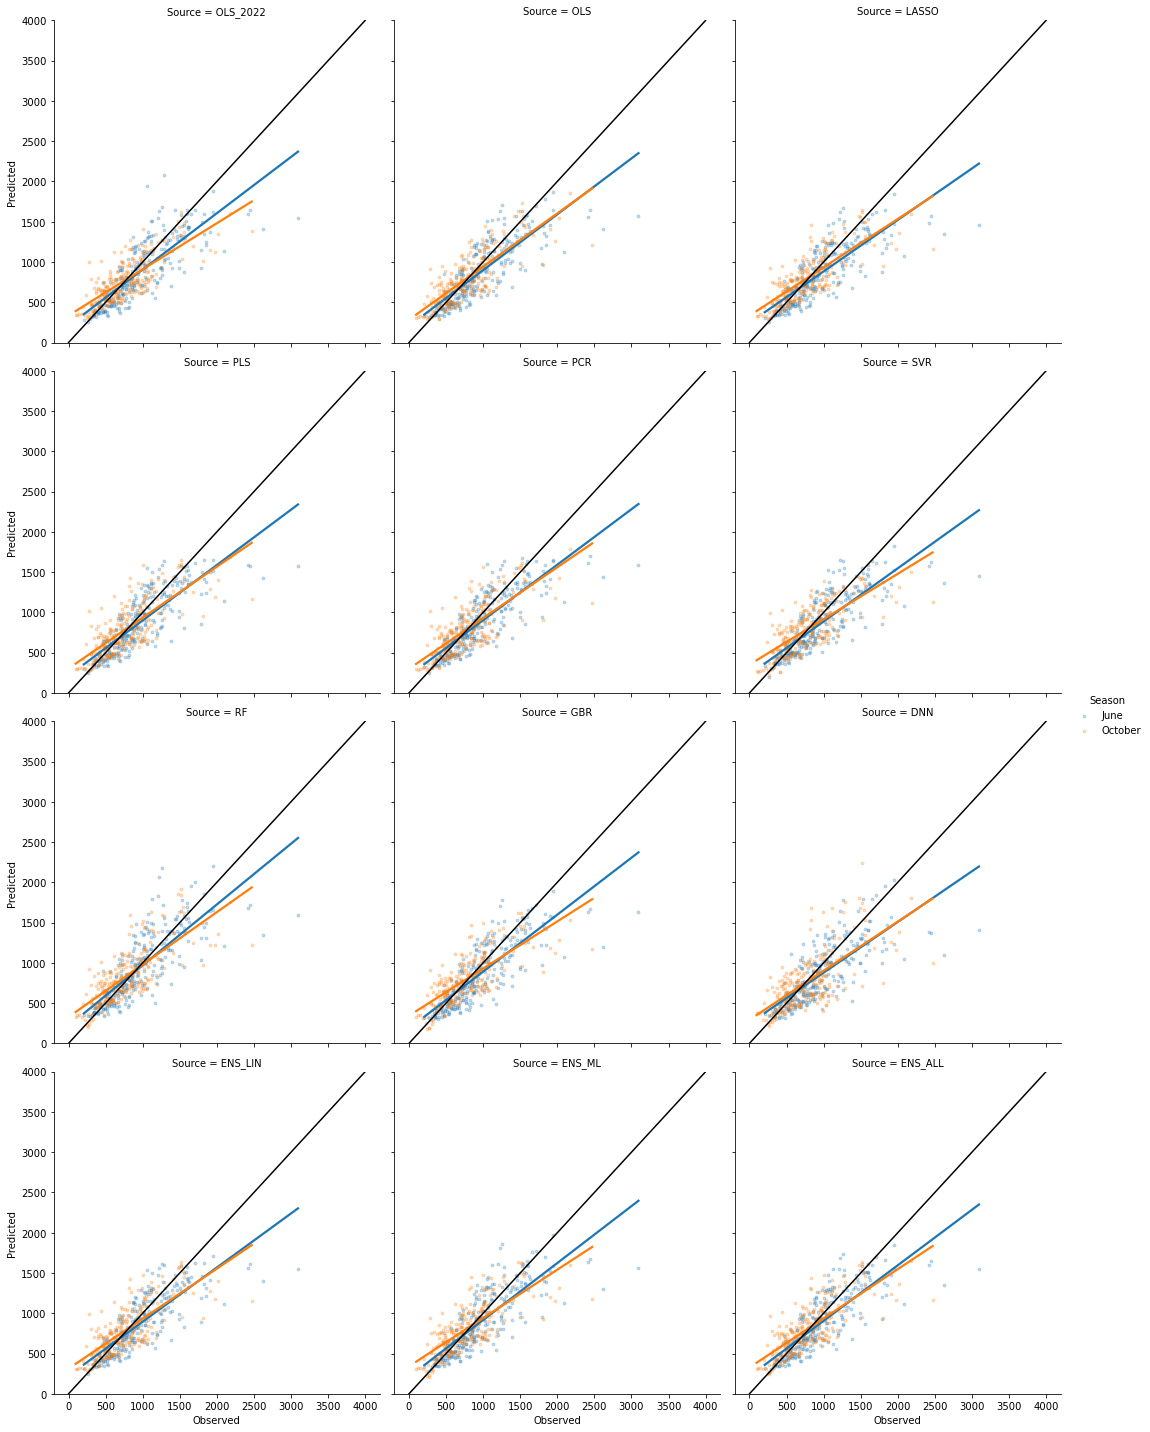

In [18]:
p_pasture_seas = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Date_mean', 'Season']).mean().reset_index(), 
               x='Observed', y='Predicted', col='Source', col_wrap=3, 
               hue='Season', ci=None, 
                       scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_pasture_seas.axes:
    ax.set_ylim((0, 4000))
    ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_pasture_by_season_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)

In [19]:
df_ols = mod_dict['OLS']['formula_df']

In [20]:
df_ols

year numb_vars                                            formula  R2_adj  \
0   2013         3                                Biomass_kg_ha ~ dfi  0.0848   
0   2013         3                               Biomass_kg_ha ~ ndvi  0.2177   
0   2013         3                               Biomass_kg_ha ~ ndti  0.4834   
0   2013         3                              Biomass_kg_ha ~ satvi  0.2007   
0   2013         3                              Biomass_kg_ha ~ ndii7  0.2186   
..   ...       ...                                                ...     ...   
0   2022         3  Biomass_kg_ha ~ swir2 + bai_236 + bai_346 + sw...  0.5900   
0   2022         3  Biomass_kg_ha ~ bai_126 + bai_136 + bai_246 + ...  0.1731   
0   2022         3  Biomass_kg_ha ~ bai_126 + bai_136 + bai_346 + ...  0.1774   
0   2022         3  Biomass_kg_ha ~ bai_126 + bai_236 + bai_246 + ...  0.1713   
0   2022         3  Biomass_kg_ha ~ bai_126 + bai_236 + bai_346 + ...  0.1768   

           AIC  mae_orig_mean  
0   12970.7611         0.4623  
0   11776.3751         0.4277  
0    8614.1552         0.3388  
0   11937.1180         0.4368  
0   11768.2519         0.4246  
..         ...            ...  
0    5729.6530         0.2984  
0   10746.6789         0.4612  
0   10709.9960         0.4603  
0   10762.3415         0.4621  
0   10715.1433         0.4610  

[16120 rows x 6 columns]

In [21]:
df_ols['features'] = df_ols['formula'].apply(lambda x: [f for f in x.split(' ~ ')[-1].split(' + ') if ':' not in f])

In [22]:
from tqdm import tqdm
"""
Calculated weighted relative variable importance for each variable across model types
"""
# set max vars based on where cross-validated metrics stop improving
max_vars = 3

var_names = list(set(df_ols['features'].sum()))

# Calculate decomposed R^2, relative variable importance (RVI) and AIC weights
df_ols_feats_ptn = pd.DataFrame(columns=['year', 'features', 'formula', 'RVI', 'weight'])
for k in df_ols['year'].unique():
    print(k)
    df_ols_sub_tmp = df_ols[(df_ols['year'] == k) &
    (df_ols['numb_vars'] <= max_vars)].copy()
    min_aic = (df_ols_sub_tmp['AIC']*0.001).min()
    df_ols_sub_tmp['AICw'] = [np.exp(-0.5 * x) for x in (df_ols_sub_tmp['AIC']*0.001 - min_aic)] / \
    np.sum([np.exp(-0.5 * x) for x in (df_ols_sub_tmp['AIC']*0.001 - min_aic)])
    for f in tqdm(var_names):
        df_ols_sub_f = df_ols_sub_tmp[[f in n for n in df_ols_sub_tmp['formula']]]
        if len(df_ols_sub_f) == 0:
            continue
        else:
            for f_form in df_ols_sub_f['formula']:
                f_form_omitted = re.sub(f + ":[^\+]* \+ ", "",
                                        re.sub(" \+ " + f + ":[^\+]*", "",
                                               re.sub(" \+ " + f + ":.+?(?= |$)", "",
                                                      re.sub(" \+(?<=\+)[^\+]*:" + f, "",
                                                             re.sub("\+ " + f + " (?=\+)", "",
                                                                    re.sub("(?<=~ )" + f + " \+ ", "",
                                                                           f_form))))))

                # print(f_form)
                # print(f_form_omitted)
                RVI_tmp = df_ols_sub_tmp['R2_adj'][(df_ols_sub_tmp['formula'] == f_form)].values - \
                          df_ols_sub_tmp['R2_adj'][(df_ols_sub_tmp['formula'] == f_form_omitted)].values
                OVI_tmp = df_ols_sub_tmp['mae_orig_mean'][(df_ols_sub_tmp['formula'] == f_form)].values - \
                          df_ols_sub_tmp['mae_orig_mean'][(df_ols_sub_tmp['formula'] == f_form_omitted)].values
                weight_tmp = df_ols_sub_tmp['AICw'][(df_ols_sub_tmp['formula'] == f_form)].values

                df_ols_feats_tmp = pd.DataFrame(dict(year=k,
                                                     features=f,
                                                     formula=f_form,
                                                     RVI=np.mean(RVI_tmp),
                                                     weight=weight_tmp),
                                                index=[0])
                df_ols_feats_ptn = pd.concat([df_ols_feats_ptn,df_ols_feats_tmp])

2013


100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


2014


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


2015


100%|██████████| 28/28 [00:08<00:00,  3.21it/s]


2016


100%|██████████| 28/28 [00:08<00:00,  3.11it/s]


2017


100%|██████████| 28/28 [00:09<00:00,  2.85it/s]


2018


100%|██████████| 28/28 [00:10<00:00,  2.63it/s]


2019


100%|██████████| 28/28 [00:10<00:00,  2.57it/s]


2020


100%|██████████| 28/28 [00:11<00:00,  2.46it/s]


2021


100%|██████████| 28/28 [00:11<00:00,  2.43it/s]


2022


100%|██████████| 28/28 [00:11<00:00,  2.36it/s]


In [23]:
def feature_type(f):
    if f in ['red', 'green', 'blue', 'nir', 'swir1', 'swir2']:
        return 'Band'
    elif 'bai' in f:
        return 'BAI'
    else:
        return 'Veg. Index'

# calculate weighted relative variable importance (RVIw)
df_ols_feats_ptn['RVIw'] = df_ols_feats_ptn['RVI'] * df_ols_feats_ptn['weight']

# add input variable group field
df_ols_feats_ptn['group'] = df_ols_feats_ptn['features'].apply(feature_type)

# calculate sorted mean RVIw for each feature after summing across each kfold
df_ols_feats_grp = df_ols_feats_ptn.groupby(['year',
                                             'features',
                                             'group'])['RVIw'].sum().reset_index()
df_ols_feats_grp['RVIw_mean'] = df_ols_feats_grp.groupby(['features'])['RVIw'].transform('mean')
df_ols_feats_grp = df_ols_feats_grp.sort_values(['RVIw_mean'], ascending=False).reset_index(drop=True)

In [33]:
df_ols_feats_grp['year'] = df_ols_feats_grp['year'].astype('str')
df_ols_feats_grp['year'] = pd.Categorical(df_ols_feats_grp['year'], 
                                          [str(x) for x in range(min(df_ols_feats_grp['year'].astype(int)),
                                                                 max(df_ols_feats_grp['year'].astype(int))+1)])

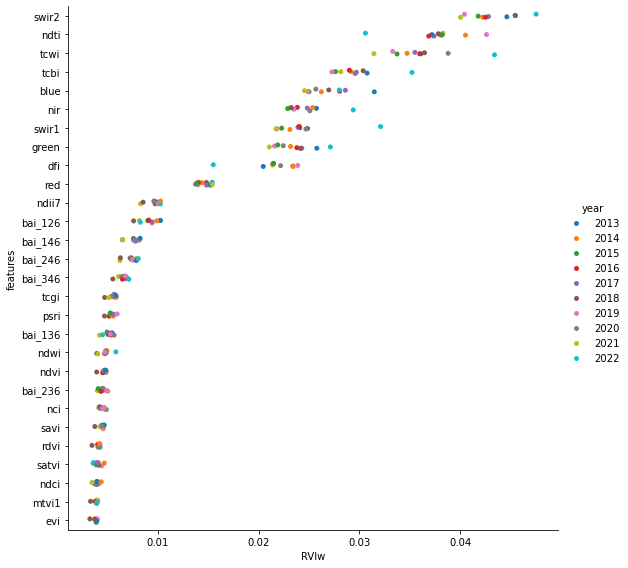

In [34]:
p = sns.catplot(y='features', x='RVIw', hue='year',# hue_order=['Band', 'Veg. Index', 'BAI'],
                orient='h',# palette=sns.color_palette()[6:-1],
                data=df_ols_feats_grp,
                height=8, aspect=1.0)

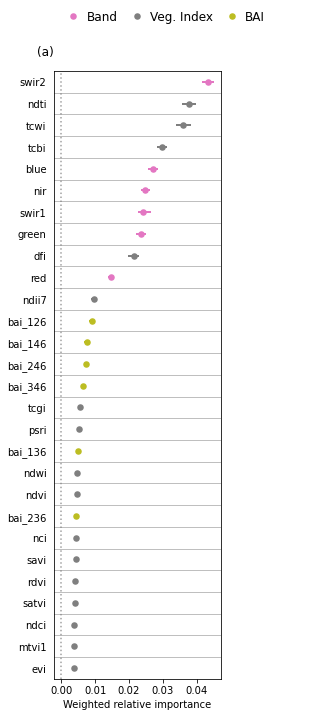

In [24]:
"""
Figure 2: Plot variable importance calculated from all model subsets
"""
font_sml = 10
font_med=12
fig = plt.figure(figsize=(6, 10))
ax1 = fig.add_subplot(1, 2, 1)
pplot1 = sns.pointplot(y='features', x='RVIw', hue='group', hue_order=['Band', 'Veg. Index', 'BAI'],
                       orient='h', dodge=False, ax=ax1, linestyles='None', linewidth=2.0,
                       palette=sns.color_palette()[6:-1],
                       err_kws=dict(linewidth=2.0),
                       data=df_ols_feats_grp)
ax1.set_ylabel('')
ax1.set_xlabel('Weighted relative importance', fontsize=font_sml)
ax1.get_legend().remove()
#ax1.set_xlim((-0.10, 0.50))
ax1.set_yticks(np.arange(0.5, len(df_ols_feats_grp['features'].unique()) - 1, 1), minor=True)
ax1.grid(which='minor', axis='y')
for tic in ax1.yaxis.get_major_ticks():
    tic.tick1line.set_visible(False)
    tic.tick2line.set_visible(False)
for tic in ax1.yaxis.get_minor_ticks():
    tic.tick1line.set_visible(False)
    tic.tick2line.set_visible(False)
ax1.axvline(x=0, color='grey', alpha=0.75, linestyle='dotted')
ax1.tick_params(axis='x', which='major', labelsize=font_sml)
ax1.tick_params(axis='y', which='major', labelsize=font_sml)
ax1.text(x=-0.1, y=1.025, s='(a)', transform=ax1.transAxes, size=font_med)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), fontsize=font_med,
           columnspacing=0.6, handletextpad=0.1, frameon=False)
plt.tight_layout(w_pad=3.0, rect=(0, 0, 1, 0.95))
if save_results:
    plt.savefig(outDIR_figs + mod_dir_dict[mod_type] + mod_type + '_variable_importance.png', dpi=600,
                bbox_inches='tight', pad_inches=0.2)
    plt.close()

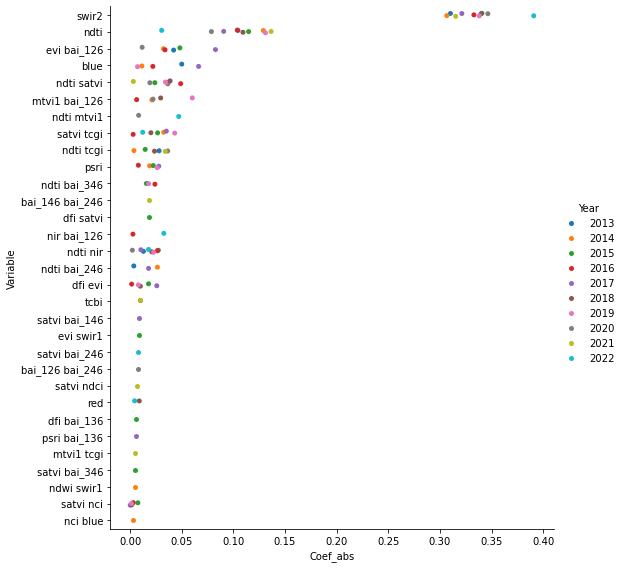

In [35]:
df_lasso_coefs = mod_dict['LASSO']['variable_df']
df_lasso_coefs['Coef_abs'] = abs(df_lasso_coefs['Coef'])
df_lasso_coefs_ranked = df_lasso_coefs.groupby('Variable')['Coef_abs'].mean().sort_values(ascending=False)
df_lasso_coefs['Variable'] = pd.Categorical(df_lasso_coefs['Variable'], categories=df_lasso_coefs_ranked.index.values)
p = sns.catplot(df_lasso_coefs, x='Coef_abs', y='Variable', hue='Year', height=8, aspect=1.0, orient='h')
#for ax in p.axes.flatten():
#    ax.tick_params(axis='x', rotation=90)

In [36]:
df_lasso_coefs.groupby('Variable')['Coef'].count().sort_values(ascending=False)

Variable
swir2              10
ndti               10
ndti satvi          9
ndti nir            8
satvi tcgi          7
evi bai_126         6
ndti tcgi           6
blue                5
mtvi1 bai_126       5
satvi nci           5
psri                5
dfi evi             5
ndti bai_246        3
ndti bai_346        3
nir bai_126         2
red                 2
ndti mtvi1          2
tcbi                2
ndwi swir1          1
satvi bai_346       1
mtvi1 tcgi          1
psri bai_136        1
dfi bai_136         1
satvi ndci          1
dfi satvi           1
bai_126 bai_246     1
satvi bai_246       1
evi swir1           1
satvi bai_146       1
bai_146 bai_246     1
nci blue            1
Name: Coef, dtype: int64

In [37]:
df_lasso_coefs.groupby('Year')['Coef'].count()

Year
2013     8
2014    12
2015    15
2016    13
2017    13
2018    11
2019    11
2020     9
2021     8
2022     8
Name: Coef, dtype: int64

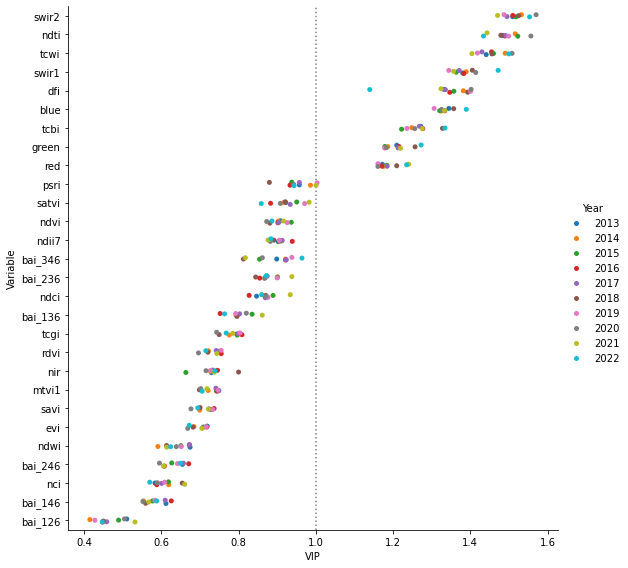

In [46]:
df_vip = mod_dict['PLS']['variable_df']
df_vip_ranked = df_vip.groupby('Variable')['VIP'].mean().sort_values(ascending=False)
df_vip['Variable'] = pd.Categorical(df_vip['Variable'], categories=df_vip_ranked.index.values)
df_vip_top = df_vip[df_vip['VIP'] > 1.0].copy()
df_vip_top['Variable'] = df_vip_top['Variable'].cat.remove_unused_categories()
p = sns.catplot(df_vip, x='VIP', y='Variable',  hue='Year', height=8, aspect=1.0, orient='h')
for ax in p.axes.flatten():
    ax.axvline(x=1.0, linestyle='dotted', color='grey')

In [47]:
df_vip[df_vip['VIP'] > 1.0].groupby('Variable')['VIP'].count().sort_values(ascending=False)

Variable
swir2      10
ndti       10
tcwi       10
swir1      10
dfi        10
blue       10
tcbi       10
green      10
red        10
psri        2
bai_146     0
nci         0
bai_246     0
ndwi        0
nir         0
evi         0
savi        0
mtvi1       0
bai_236     0
rdvi        0
tcgi        0
bai_136     0
ndci        0
bai_346     0
ndii7       0
ndvi        0
satvi       0
bai_126     0
Name: VIP, dtype: int64

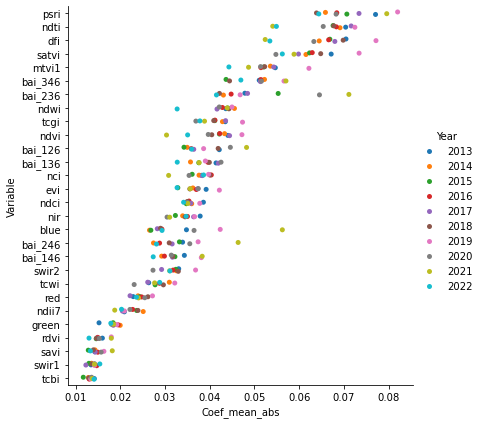

In [48]:
df_pcr_coefs = mod_dict['PCR']['variable_df']
pcr_coefs_abs_mean = df_pcr_coefs.groupby(['Year', 'Variable']).apply(lambda x: np.mean(np.abs(x), axis=1))
pcr_coefs_abs_mean.name = 'Coef_mean_abs'
df_pcr_coefs_mean = pcr_coefs_abs_mean.reset_index()

pcr_vars_mean_ranked = df_pcr_coefs_mean.groupby('Variable')['Coef_mean_abs'].mean().sort_values(ascending=False)
df_pcr_coefs_mean['Variable'] = pd.Categorical(df_pcr_coefs_mean['Variable'], categories=pcr_vars_mean_ranked.index.values)

df_pcr_coefs_mean_top20 = df_pcr_coefs_mean[df_pcr_coefs_mean['Variable'].isin(pcr_vars_mean_ranked.head(20).index.values)].copy()
df_pcr_coefs_mean_top20['Variable'] = df_pcr_coefs_mean_top20['Variable'].cat.remove_unused_categories()

p = sns.catplot(df_pcr_coefs_mean,
                x='Coef_mean_abs', y='Variable',  hue='Year', height=6, aspect=1, orient='h')

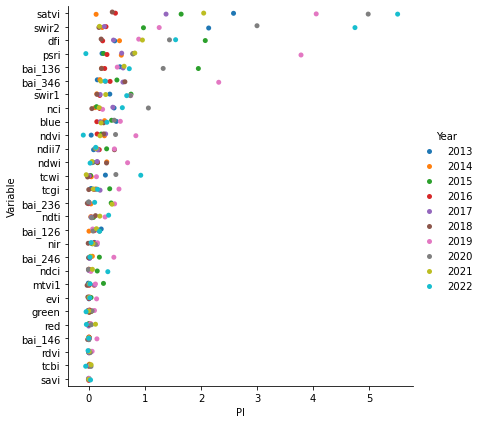

In [49]:
df_svr_pi = mod_dict['SVR']['variable_df']
df_svr_pi_ranked = df_svr_pi.groupby('Variable')['PI'].mean().sort_values(ascending=False)
df_svr_pi['Variable'] = pd.Categorical(df_svr_pi['Variable'], categories=df_svr_pi_ranked.index.values)
p = sns.catplot(df_svr_pi,
                x='PI', y='Variable',  hue='Year', height=6, aspect=1, orient='h')

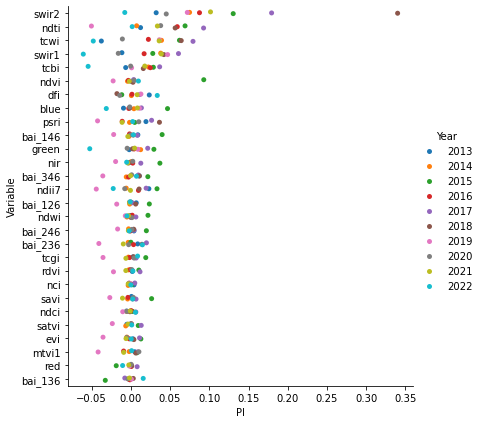

In [50]:
df_rf_pi = mod_dict['RF']['variable_df']
df_rf_pi_ranked = df_rf_pi.groupby('Variable')['PI'].mean().sort_values(ascending=False)
df_rf_pi['Variable'] = pd.Categorical(df_rf_pi['Variable'], categories=df_rf_pi_ranked.index.values)
p = sns.catplot(df_rf_pi,
                x='PI', y='Variable',  hue='Year', height=6, aspect=1, orient='h')

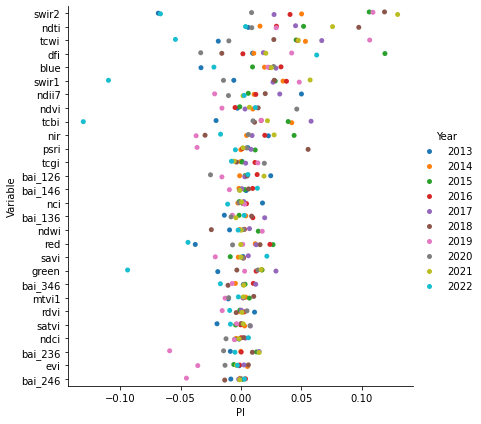

In [51]:
df_gbr_pi = mod_dict['GBR']['variable_df']
df_gbr_pi_ranked = df_gbr_pi.groupby('Variable')['PI'].mean().sort_values(ascending=False)
df_gbr_pi['Variable'] = pd.Categorical(df_gbr_pi['Variable'], categories=df_gbr_pi_ranked.index.values)
p = sns.catplot(df_gbr_pi,
                x='PI', y='Variable',  hue='Year', height=6, aspect=1, orient='h')

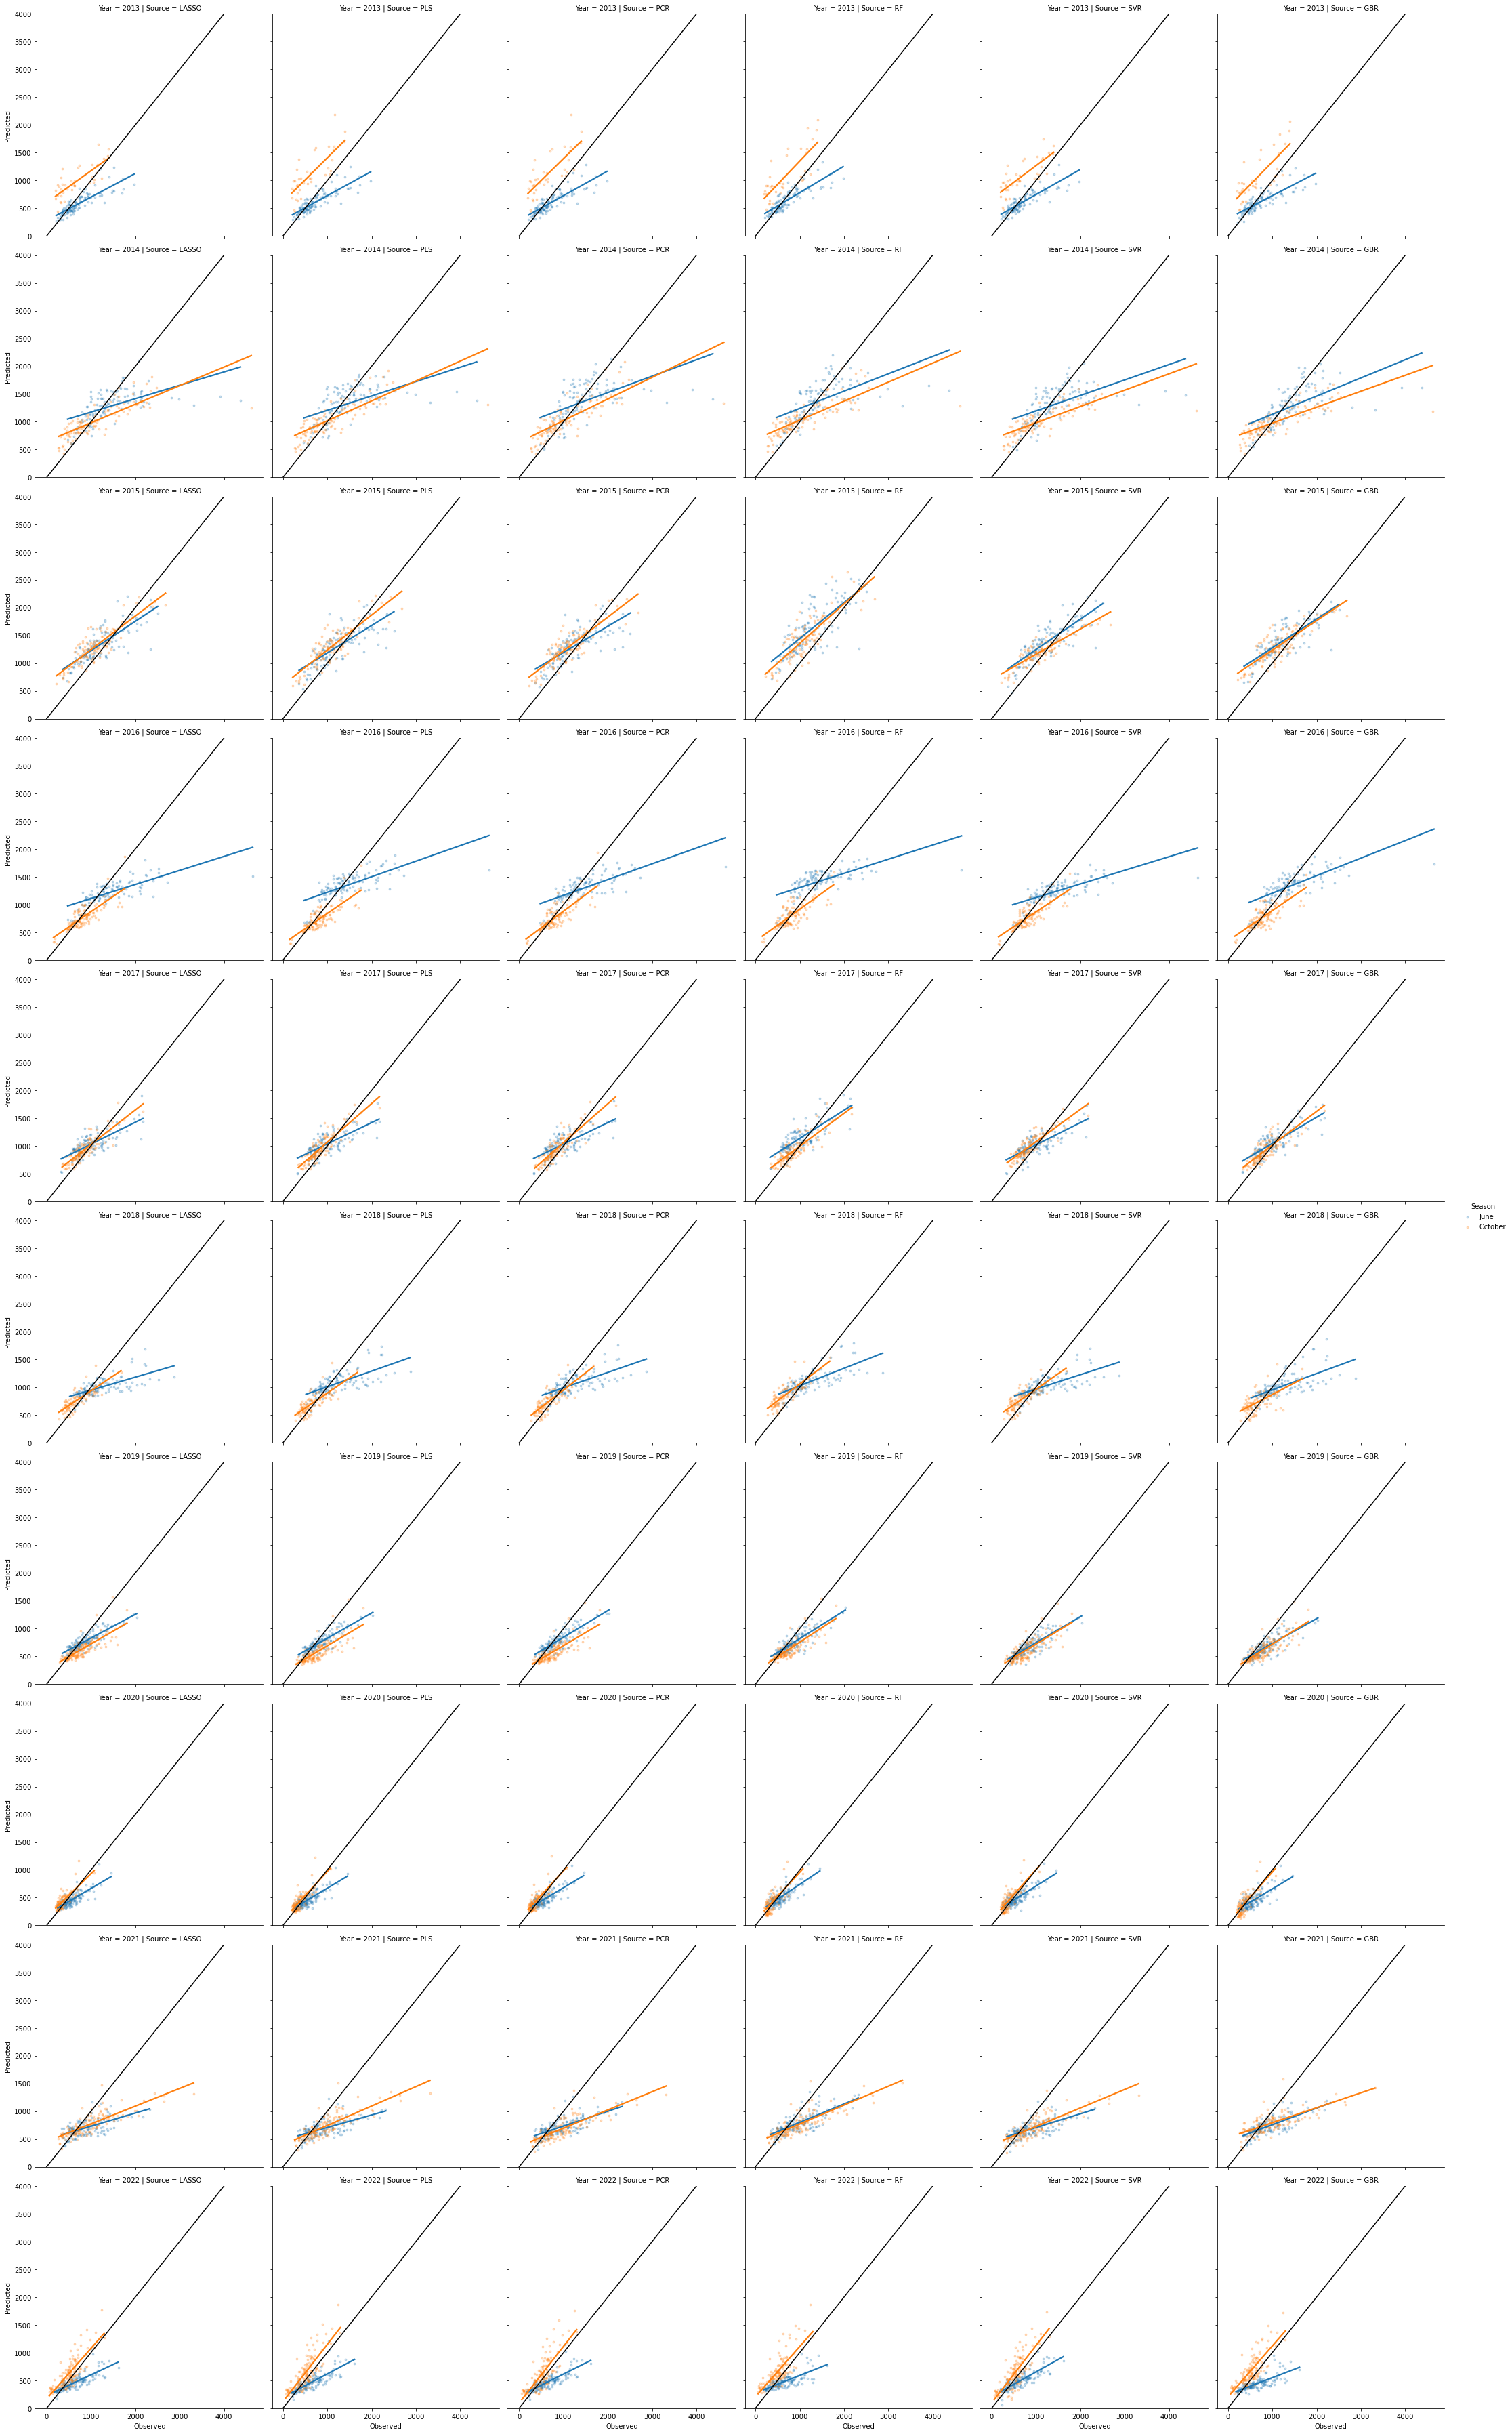

In [52]:
p_plot_seas = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Plot', 'Season']).mean().reset_index(),
               x='Observed', y='Predicted', col='Source', row='Year', col_order=['LASSO', 'PLS', 'PCR', 'RF', 'SVR', 'GBR'],
               hue='Season', ci=None, order=1,
                    scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_plot_seas.axes.flatten():
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')

In [54]:
param_dfs = {}
for k in mod_dict:
    if 'tune_results' in mod_dict[k].keys():
        for idx, yr in enumerate(mod_dict[k]['tune_results']):
            if idx == 0:
                param_names = list(np.unique([list(x.keys()) for x in mod_dict[k]['tune_results'][yr]['params']]))
                param_dfs[k] = pd.DataFrame(columns=['Model', 'Year', 'Best', 'MAPE', 'MSE', 'R2', 'R2_train'] + param_names)
            df_tmp = pd.DataFrame({'Model': k,
                                   'Year': str(yr),
                                   'Best': 0,
                                   'MAPE': mod_dict[k]['tune_results'][yr]['mean_test_MAPE'],
                                   'MSE': mod_dict[k]['tune_results'][yr]['mean_test_MSE'],
                                   'R2': mod_dict[k]['tune_results'][yr]['mean_test_R2'],
                                   'R2_train': mod_dict[k]['tune_results'][yr]['mean_train_R2']})
            for p in param_names:
                df_tmp[p] = mod_dict[k]['tune_results'][yr]['param_' + p].data
            idx_best = mod_dict[k]['tune_results'][yr]['rank_test_MAPE'].argmin()
            df_tmp.loc[idx_best, 'Best'] = 1
            param_dfs[k] = pd.concat([param_dfs[k], df_tmp])
        if k in param_dfs.keys():
            param_dfs[k] = param_dfs[k].reset_index(drop=True)

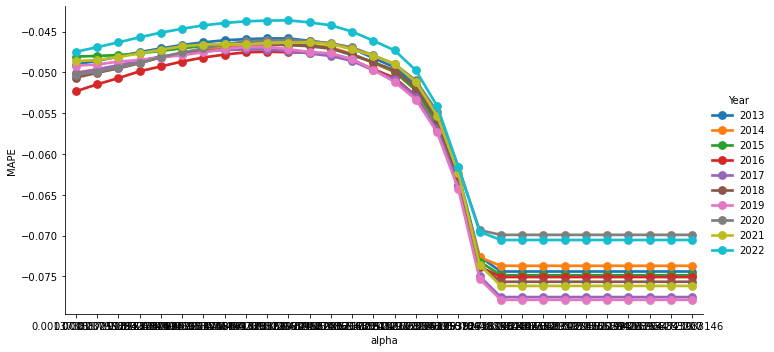

In [55]:
sns.catplot(x='alpha', y='MAPE', data=param_dfs['LASSO'], hue='Year', kind='point', aspect=2)

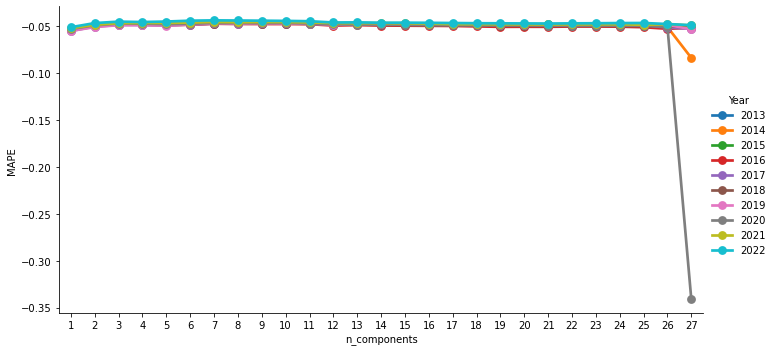

In [56]:
sns.catplot(x='n_components', y='MAPE', data=param_dfs['PLS'], hue='Year', kind='point', aspect=2)

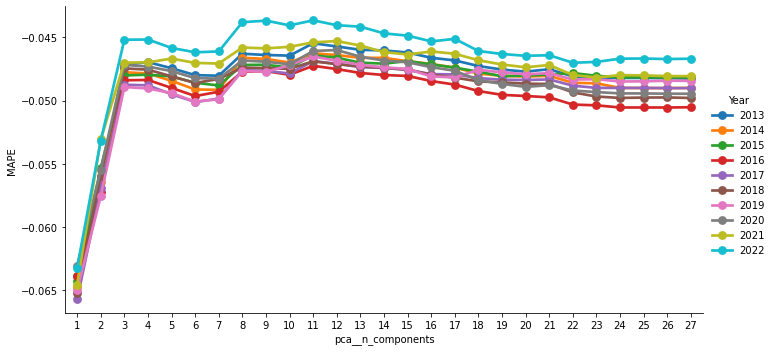

In [57]:
sns.catplot(x='pca__n_components', y='MAPE', data=param_dfs['PCR'], hue='Year', kind='point', aspect=2)

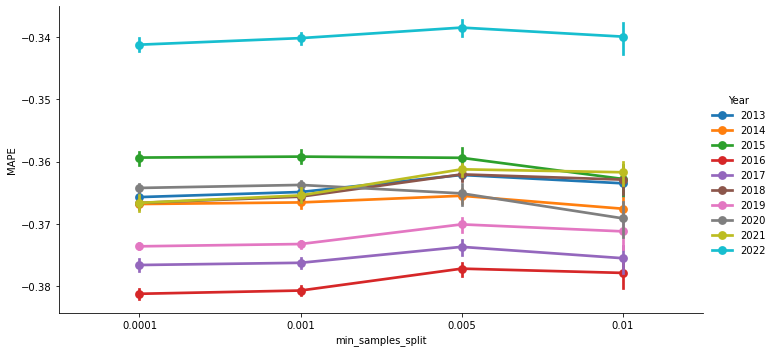

In [58]:
sns.catplot(x='min_samples_split', y='MAPE', data=param_dfs['RF'], hue='Year', kind='point', aspect=2)

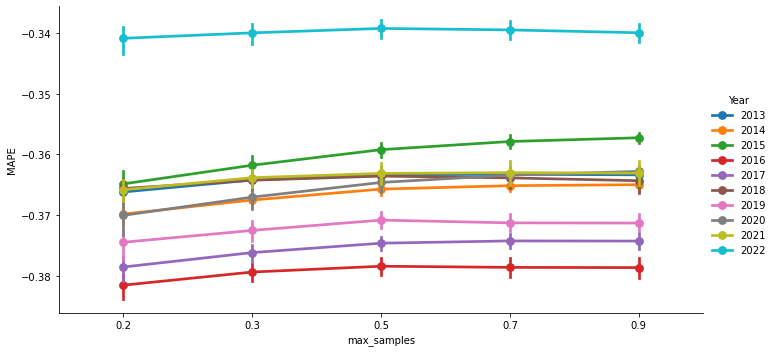

In [59]:
sns.catplot(x='max_samples', y='MAPE', data=param_dfs['RF'], hue='Year', kind='point', aspect=2)

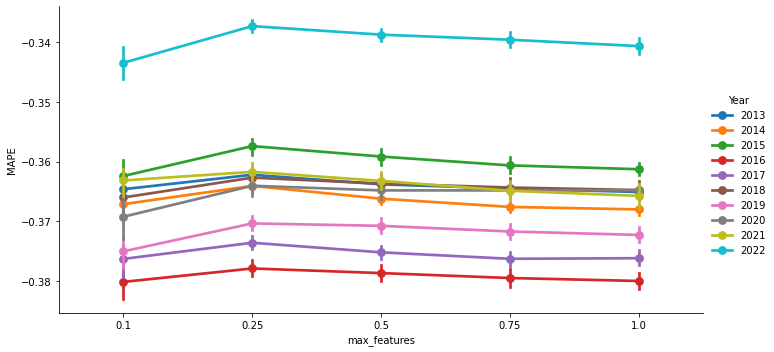

In [63]:
sns.catplot(x='max_features', y='MAPE', data=param_dfs['RF'], hue='Year', kind='point', aspect=2)

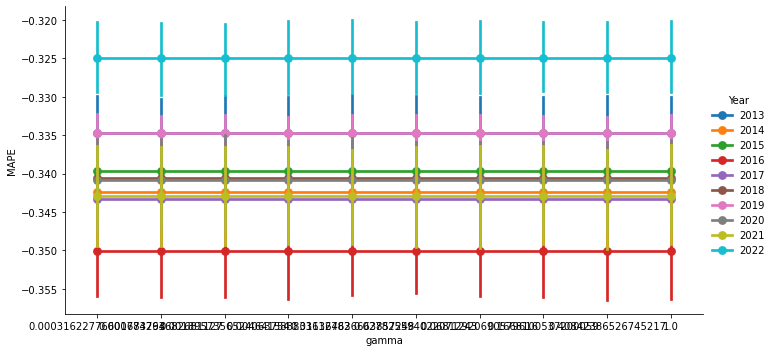

In [64]:
sns.catplot(x='gamma', y='MAPE', data=param_dfs['SVR'], hue='Year', kind='point', aspect=2)

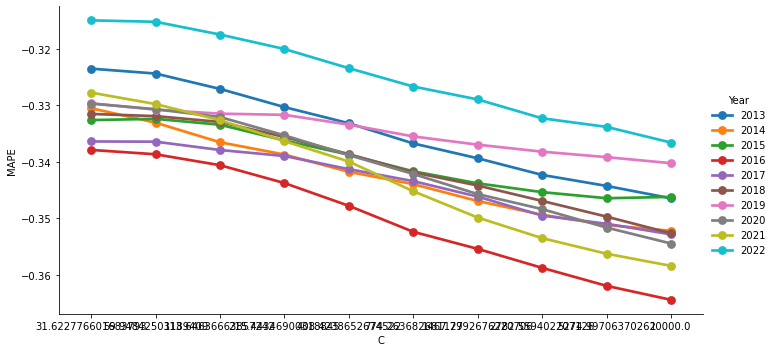

In [65]:
sns.catplot(x='C', y='MAPE', data=param_dfs['SVR'], hue='Year', kind='point', aspect=2)

In [78]:
np.logspace(0.5, 4, 15, base=10)

array([3.16227766e+00, 5.62341325e+00, 1.00000000e+01, 1.77827941e+01,
       3.16227766e+01, 5.62341325e+01, 1.00000000e+02, 1.77827941e+02,
       3.16227766e+02, 5.62341325e+02, 1.00000000e+03, 1.77827941e+03,
       3.16227766e+03, 5.62341325e+03, 1.00000000e+04])

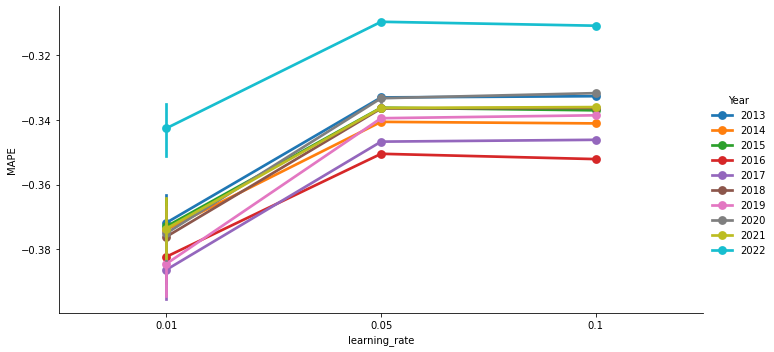

In [67]:
sns.catplot(x='learning_rate', y='MAPE', data=param_dfs['GBR'], hue='Year', kind='point', aspect=2)

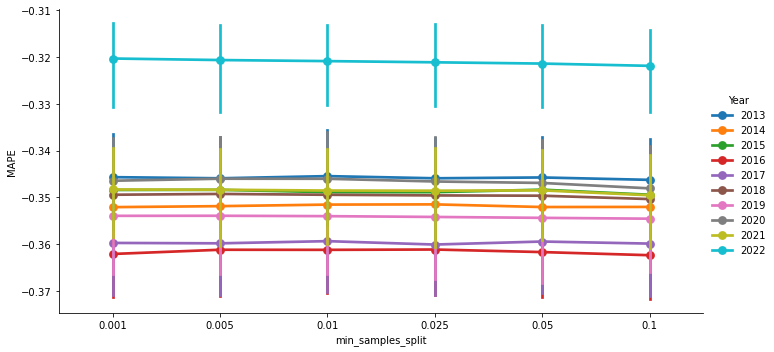

In [68]:
sns.catplot(x='min_samples_split', y='MAPE', data=param_dfs['GBR'], hue='Year', kind='point', aspect=2)

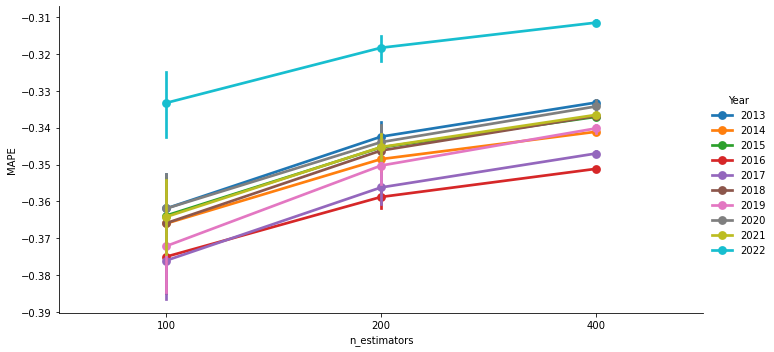

In [69]:
sns.catplot(x='n_estimators', y='MAPE', data=param_dfs['GBR'], hue='Year', kind='point', aspect=2)

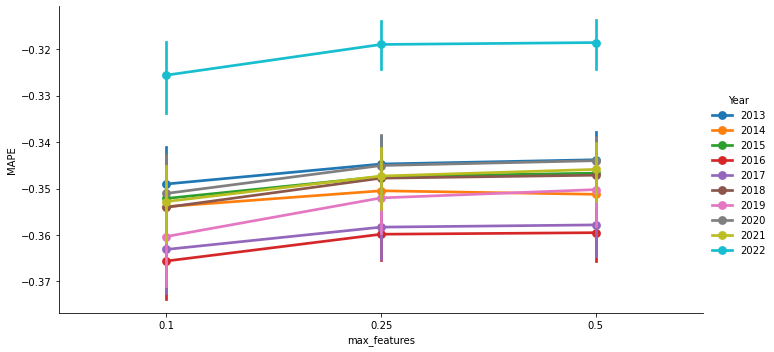

In [70]:
sns.catplot(x='max_features', y='MAPE', data=param_dfs['GBR'], hue='Year', kind='point', aspect=2)

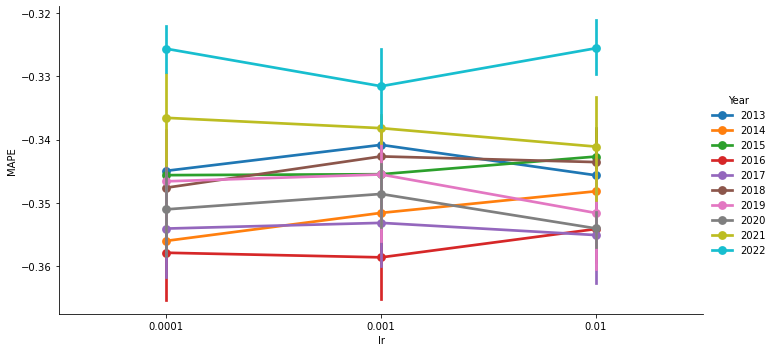

In [71]:
sns.catplot(x='lr', y='MAPE', data=param_dfs['DNN'], hue='Year', kind='point', aspect=2)

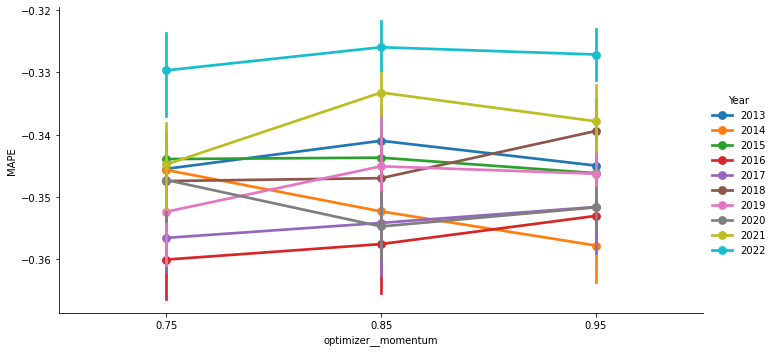

In [72]:
sns.catplot(x='optimizer__momentum', y='MAPE', data=param_dfs['DNN'], hue='Year', kind='point', aspect=2)

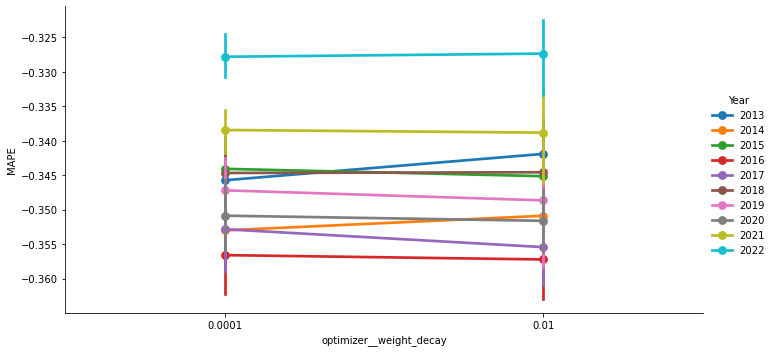

In [73]:
sns.catplot(x='optimizer__weight_decay', y='MAPE', data=param_dfs['DNN'], hue='Year', kind='point', aspect=2)

In [74]:
param_dfs['DNN'][param_dfs['DNN']['Best'] == 1].sort_values('lr')
#mod_dict['DNN2']

Model  Year Best      MAPE            MSE        R2  R2_train batch_size  \
66    DNN  2016    1 -0.341767 -175299.203993  0.263147  0.585890        256   
87    DNN  2017    1 -0.343770 -184227.025174  0.255512  0.614202        256   
122   DNN  2019    1 -0.330350 -188772.227865  0.296341  0.601351        256   
160   DNN  2021    1 -0.325282 -167117.608941  0.298736  0.620690        256   
44    DNN  2015    1 -0.333552 -157464.063802  0.350457  0.610205        256   
100   DNN  2018    1 -0.330996 -177538.365451  0.289776  0.617062        256   
133   DNN  2020    1 -0.338754 -185984.431424  0.288043  0.548750        256   
2     DNN  2013    1 -0.331112 -175290.445095  0.334141  0.578306        256   
19    DNN  2014    1 -0.334836 -134663.024957  0.347174  0.599197        256   
165   DNN  2022    1 -0.318835 -180357.713542  0.318151  0.580740        256   

         lr max_epochs                     module__block module__layers  \
66   0.0001        100  <class '__main__.ResidualBlock'>   [3, 4, 6, 3]   
87   0.0001        100  <class '__main__.ResidualBlock'>   [3, 4, 6, 3]   
122  0.0001        100  <class '__main__.ResidualBlock'>   [3, 4, 6, 3]   
160  0.0001        100  <class '__main__.ResidualBlock'>   [3, 4, 6, 3]   
44    0.001        100  <class '__main__.ResidualBlock'>   [3, 4, 6, 3]   
100   0.001        100  <class '__main__.ResidualBlock'>   [3, 4, 6, 3]   
133   0.001        100  <class '__main__.ResidualBlock'>   [3, 4, 6, 3]   
2      0.01        100  <class '__main__.ResidualBlock'>   [3, 4, 6, 3]   
19     0.01        100  <class '__main__.ResidualBlock'>   [3, 4, 6, 3]   
165    0.01        100  <class '__main__.ResidualBlock'>   [3, 4, 6, 3]   

    module__n_inputs optimizer__momentum optimizer__nesterov  \
66                28                0.75                True   
87                28                0.85                True   
122               28                0.85                True   
160               28                0.95                True   
44                28                0.85                True   
100               28                0.95                True   
133               28                0.75                True   
2                 28                0.85                True   
19                28                0.75                True   
165               28                0.85                True   

    optimizer__weight_decay  
66                     0.01  
87                   0.0001  
122                    0.01  
160                    0.01  
44                     0.01  
100                    0.01  
133                  0.0001  
2                      0.01  
19                   0.0001  
165                  0.0001